In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import json
from utils import plot_timeseries_with_metadata, create_bounding_boxes, save_yolo_labels, visualize_bounding_boxes
from tqdm import tqdm

In [2]:
class PeakDetectPatient:
    def __init__(self, patient_id="03", root_path="NAVA_original/000_CNN_PeakDetectionData/"):
        self.patient_id = patient_id
        self.root_path = root_path
        self.all_os_paths = self.collect_os_paths_of_patient_data()
        self.peak_review_dict = self.get_peak_review_data()
        self.edi_sample_data_dict = self.get_edi_sample_data()
        self.edi_flow_pressure_data_dict = self.get_edi_flow_pressure_data()

        # self.check_missingness()
    
    def find_data_start_row(self, os_path, threshold=0.5):
        """
        Find the first row in an Excel file where data actually starts.
        Reads the file and finds the first row where at least 'threshold' fraction
        of columns have non-null values.
        """
        # Read the file without skipping rows to inspect all rows
        df_temp = pd.read_excel(os_path, header=None)
        
        # Find the first row where at least 'threshold' of columns are non-null
        # This row is likely the header or first data row
        for idx in range(len(df_temp)):
            non_null_ratio = df_temp.iloc[idx].notna().sum() / len(df_temp.columns)
            if non_null_ratio >= threshold:
                return idx
        
        # If no row meets the threshold, return 0 (start from beginning)
        return 0

    def collect_os_paths_of_patient_data(self):
        # go through the root path and collect os paths that starts with "edi-{patient_id}-"
        all_os_paths = []
        print(f"collecting xlsx files that starts with 'edi-{self.patient_id}-'")
        for root, dirs, files in os.walk(self.root_path):
            for file in files:
                if file.startswith(f"edi-{self.patient_id}"):
                    all_os_paths.append(os.path.join(root, file))
                if file.startswith(f"{self.patient_id}_raw"):
                    all_os_paths.append(os.path.join(root, file))
        all_os_paths.sort()
        print(f"Found {len(all_os_paths)} files for patient {self.patient_id}")
        print(all_os_paths)
        return all_os_paths

    def get_peak_review_data(self):
        # get the peak review data from the os path
        # find file that is inside Edi_peak_review folder
        peak_review_data_dict = {}
        for os_path in self.all_os_paths:
            if "Edi_peak_review" in os_path:
                st_peak_review_data = pd.read_excel(os_path, index_col=0, sheet_name="ST")
                bbb_peak_review_data = pd.read_excel(os_path, index_col=0, sheet_name="BbB")
                print(f"reading {os_path}")
                print(f"servotracker_peak_review_data shape: {st_peak_review_data.shape}")
                print(f"BbB_peak_review_data shape: {bbb_peak_review_data.shape}")
                peak_review_data_dict['ST'] = st_peak_review_data
                peak_review_data_dict['BbB'] = bbb_peak_review_data
                print("="*100)
                return peak_review_data_dict

    def get_edi_sample_data(self):
        edi_sample_data_dict = {}
        count = 1 # count=1 because file name starts with 1
        for os_path in self.all_os_paths:
            if "Edi_sample" in os_path:
                print(f"reading {os_path}")
                edi_sample_data_dict[count] = pd.read_excel(os_path, index_col=0)
                print(f"edi_sample_data_dict[{count}] shape: {edi_sample_data_dict[count].shape}")
                count += 1
        print("="*100)
        return edi_sample_data_dict
    
    def get_edi_flow_pressure_data(self):
        edi_flow_pressure_data_dict = {}
        count = 1 # count=1 because file name starts with 1
        for os_path in self.all_os_paths:
            if "Edi-flow_pressure_sample" in os_path:
                print(f"reading {os_path}")
                # Find the first row with actual data (no missing values)
                start_row = self.find_data_start_row(os_path)
                print(f"  Data starts at row {start_row} (skipping {start_row} metadata rows)")
                
                # Read the file, skipping metadata rows
                # The first non-skipped row will be treated as header by pandas
                if start_row > 0:
                    df = pd.read_excel(os_path, skiprows=range(start_row))
                else:
                    df = pd.read_excel(os_path)
                
                edi_flow_pressure_data_dict[count] = df
                print(f"edi_flow_pressure_data_dict[{count}] shape: {edi_flow_pressure_data_dict[count].shape}")
                count += 1
        print("="*100)
        return edi_flow_pressure_data_dict
        
    def check_missingness(self):# check if there is missingness in the peak_review_dict['ST']
        print(f"Missingness in ST: {self.peak_review_dict['ST'].isnull().sum()}")
        print(f"Missingness in BbB: {self.peak_review_dict['BbB'].isnull().sum()}")

        for key in self.edi_sample_data_dict.keys():
            print(f"Missingness in {key}: {self.edi_sample_data_dict[key].isnull().sum()}")
        for key in self.edi_flow_pressure_data_dict.keys():
            print(f"Missingness in {key}: {self.edi_flow_pressure_data_dict[key].isnull().sum()}")


collecting xlsx files that starts with 'edi-03-'
Found 9 files for patient 03
['../../NAVA_original/000_CNN_PeakDetectionData/Edi-flow_pressure_sample/03/03_raw-1.xlsx', '../../NAVA_original/000_CNN_PeakDetectionData/Edi-flow_pressure_sample/03/03_raw-2.xlsx', '../../NAVA_original/000_CNN_PeakDetectionData/Edi-flow_pressure_sample/03/03_raw-3.xlsx', '../../NAVA_original/000_CNN_PeakDetectionData/Edi-flow_pressure_sample/03/03_raw-4.xlsx', '../../NAVA_original/000_CNN_PeakDetectionData/Edi_peak_review/edi-03_ST vs. BbB.xlsx', '../../NAVA_original/000_CNN_PeakDetectionData/Edi_sample/03/edi-03-raw-1.xlsx', '../../NAVA_original/000_CNN_PeakDetectionData/Edi_sample/03/edi-03-raw-2.xlsx', '../../NAVA_original/000_CNN_PeakDetectionData/Edi_sample/03/edi-03-raw-3.xlsx', '../../NAVA_original/000_CNN_PeakDetectionData/Edi_sample/03/edi-03-raw-4.xlsx']
reading ../../NAVA_original/000_CNN_PeakDetectionData/Edi_peak_review/edi-03_ST vs. BbB.xlsx
servotracker_peak_review_data shape: (4772, 5)
BbB_p

Processing windows:   0%|          | 0/50 [00:00<?, ?it/s]


Processing window 1/50
  Indices: 0 to 2000
  Number of peaks in this window: 7
Actual image size: 1200x400 pixels


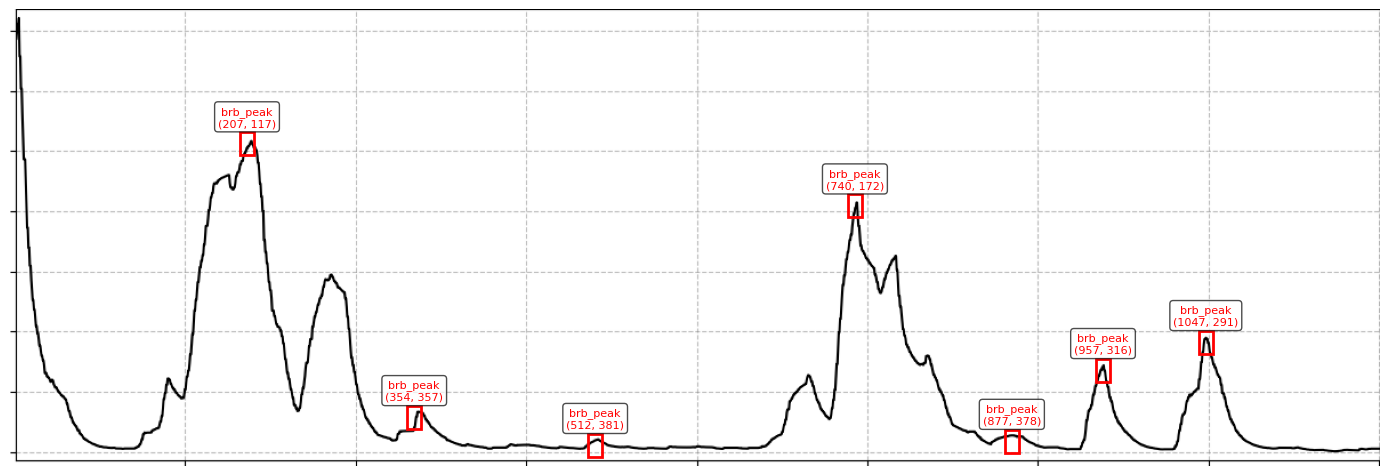

Processing windows:   2%|▏         | 1/50 [00:00<00:14,  3.29it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0000_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0000.png
  ✓ Created 7 bounding boxes

Processing window 2/50
  Indices: 2000 to 4000
  Number of peaks in this window: 8
Actual image size: 1200x400 pixels


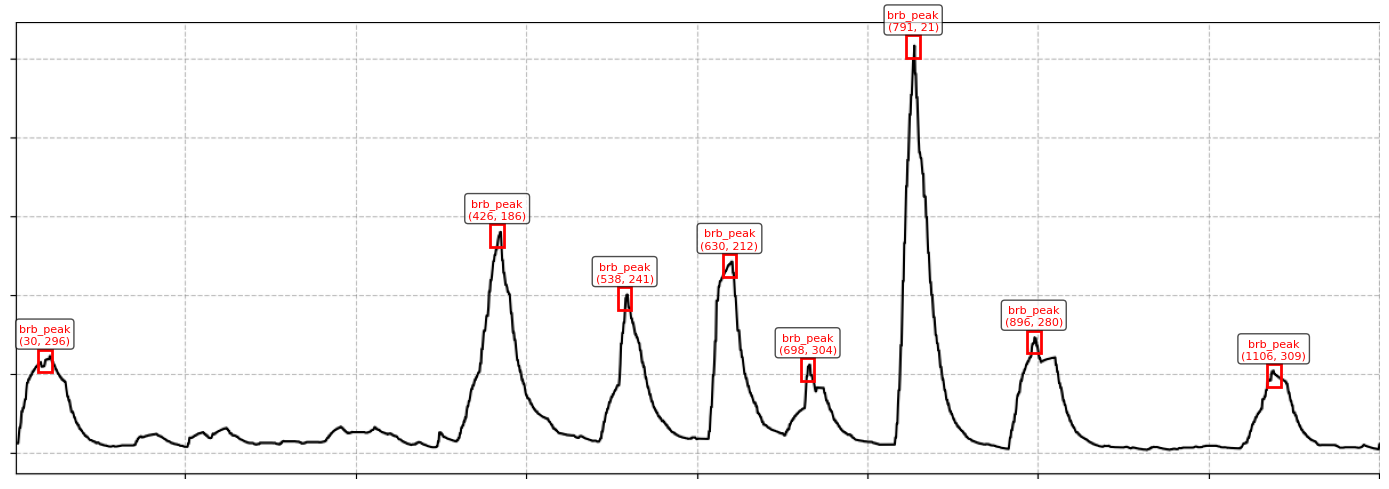

Processing windows:   4%|▍         | 2/50 [00:00<00:14,  3.31it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0001_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0001.png
  ✓ Created 8 bounding boxes

Processing window 3/50
  Indices: 4000 to 6000
  Number of peaks in this window: 9
Actual image size: 1200x400 pixels


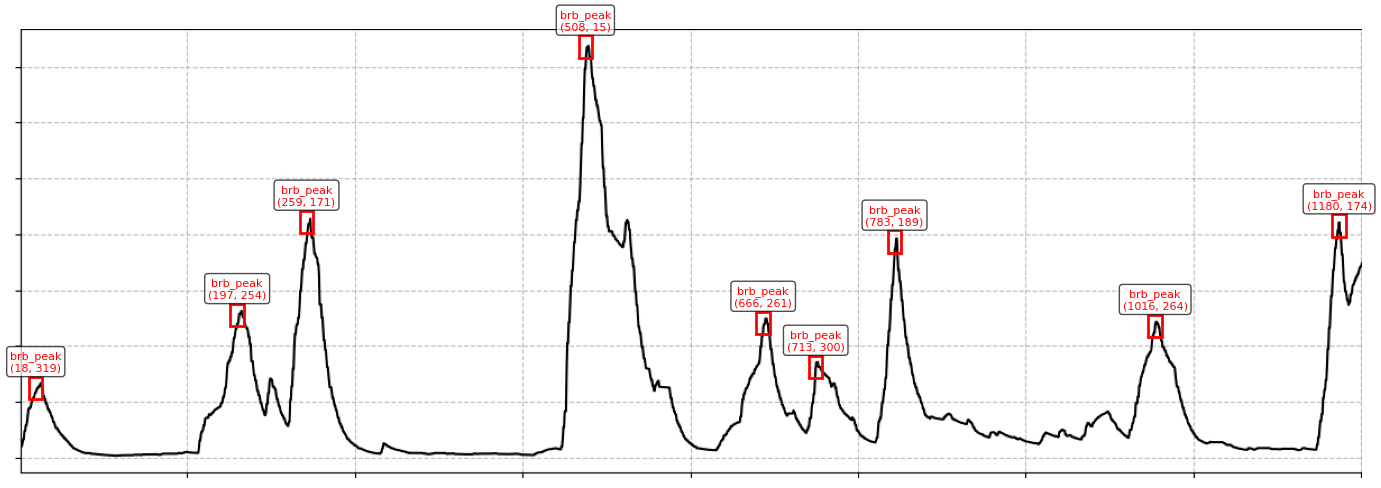

Processing windows:   6%|▌         | 3/50 [00:00<00:14,  3.33it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0002_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0002.png
  ✓ Created 9 bounding boxes

Processing window 4/50
  Indices: 6000 to 8000
  Number of peaks in this window: 9
Actual image size: 1200x400 pixels


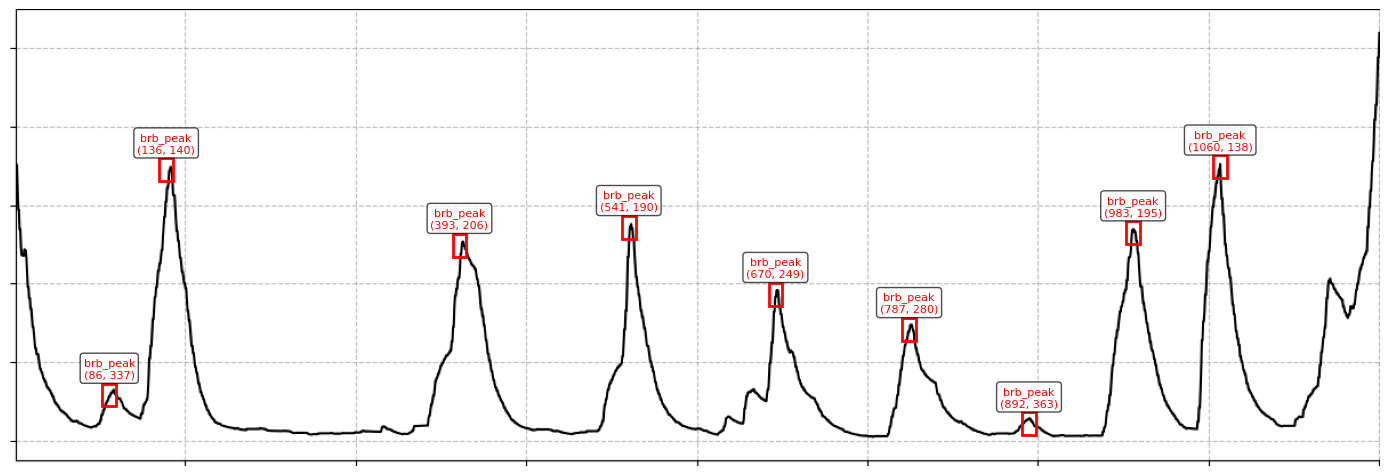

Processing windows:   8%|▊         | 4/50 [00:01<00:13,  3.32it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0003_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0003.png
  ✓ Created 9 bounding boxes

Processing window 5/50
  Indices: 8000 to 10000
  Number of peaks in this window: 11
Actual image size: 1200x400 pixels


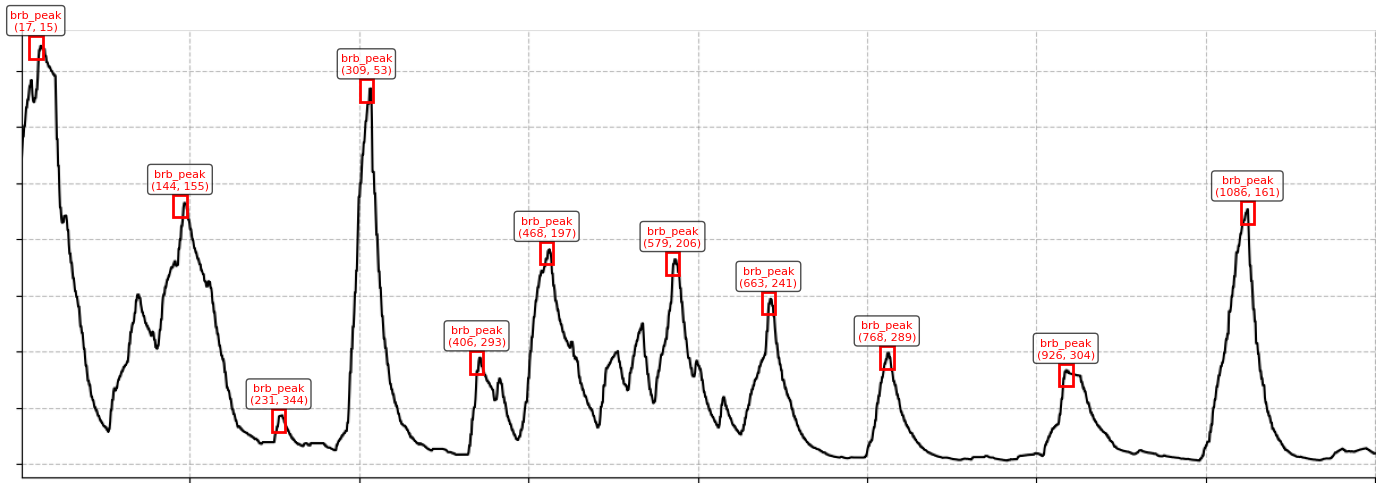

Processing windows:  10%|█         | 5/50 [00:01<00:13,  3.25it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0004_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0004.png
  ✓ Created 11 bounding boxes

Processing window 6/50
  Indices: 10000 to 12000
  Number of peaks in this window: 11
Actual image size: 1200x400 pixels


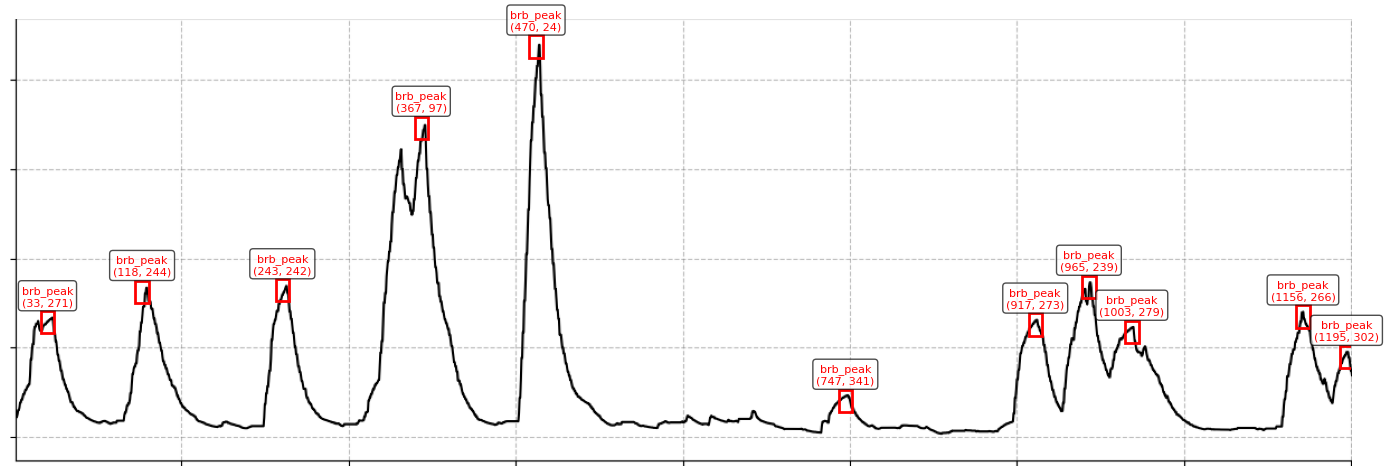

Processing windows:  12%|█▏        | 6/50 [00:01<00:13,  3.25it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0005_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0005.png
  ✓ Created 11 bounding boxes

Processing window 7/50
  Indices: 12000 to 14000
  Number of peaks in this window: 7
Actual image size: 1200x399 pixels


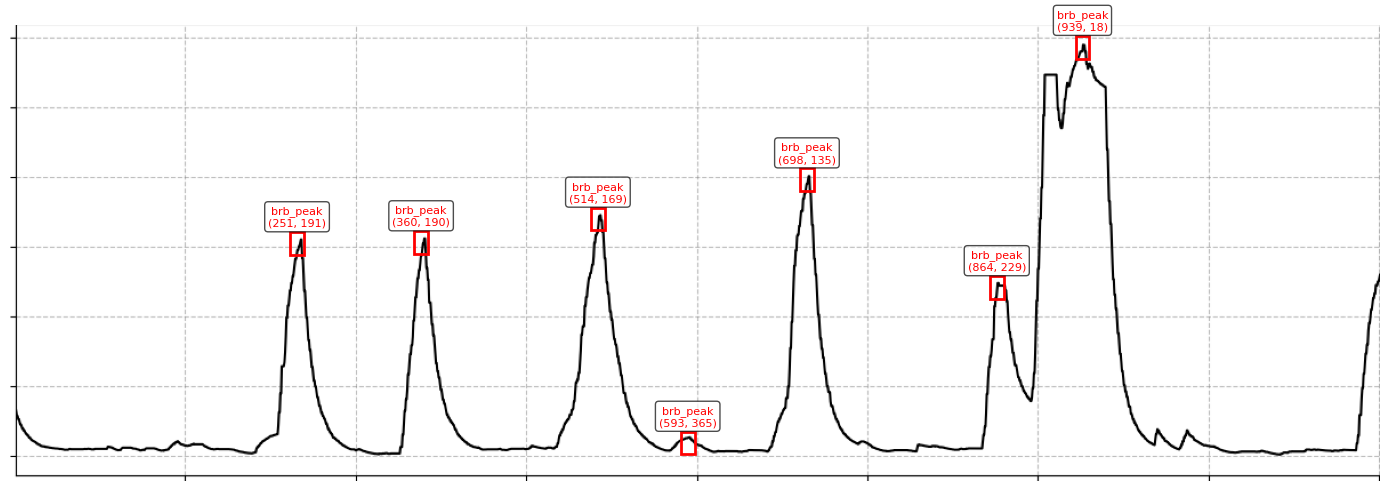

Processing windows:  14%|█▍        | 7/50 [00:02<00:13,  3.28it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0006_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0006.png
  ✓ Created 7 bounding boxes

Processing window 8/50
  Indices: 14000 to 16000
  Number of peaks in this window: 11
Actual image size: 1200x400 pixels


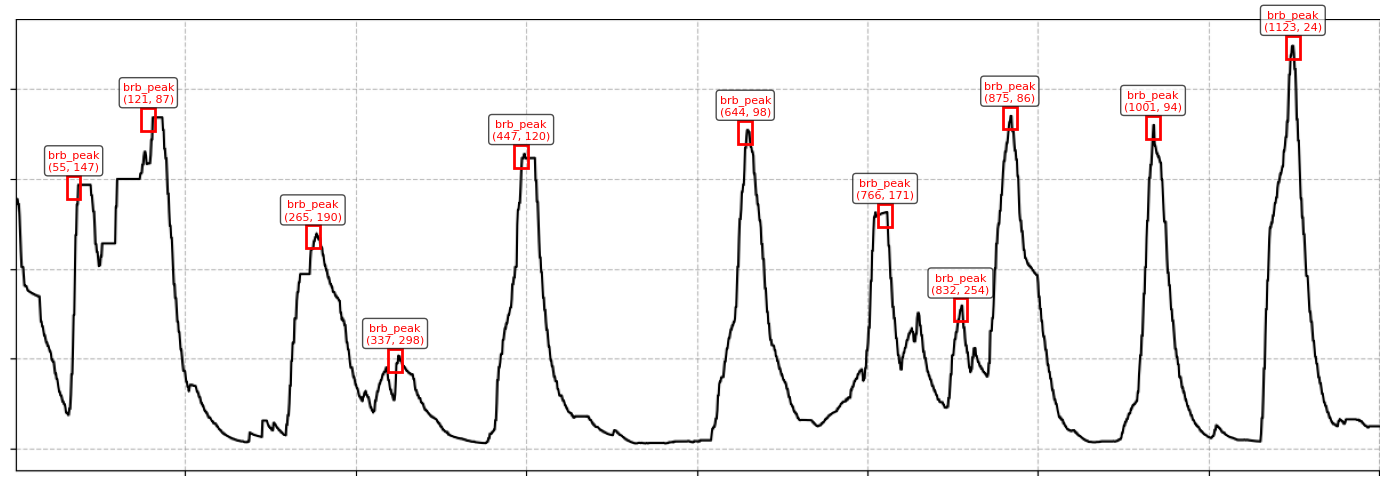

Processing windows:  16%|█▌        | 8/50 [00:02<00:12,  3.26it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0007_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0007.png
  ✓ Created 11 bounding boxes

Processing window 9/50
  Indices: 16000 to 18000
  Number of peaks in this window: 12
Actual image size: 1199x400 pixels


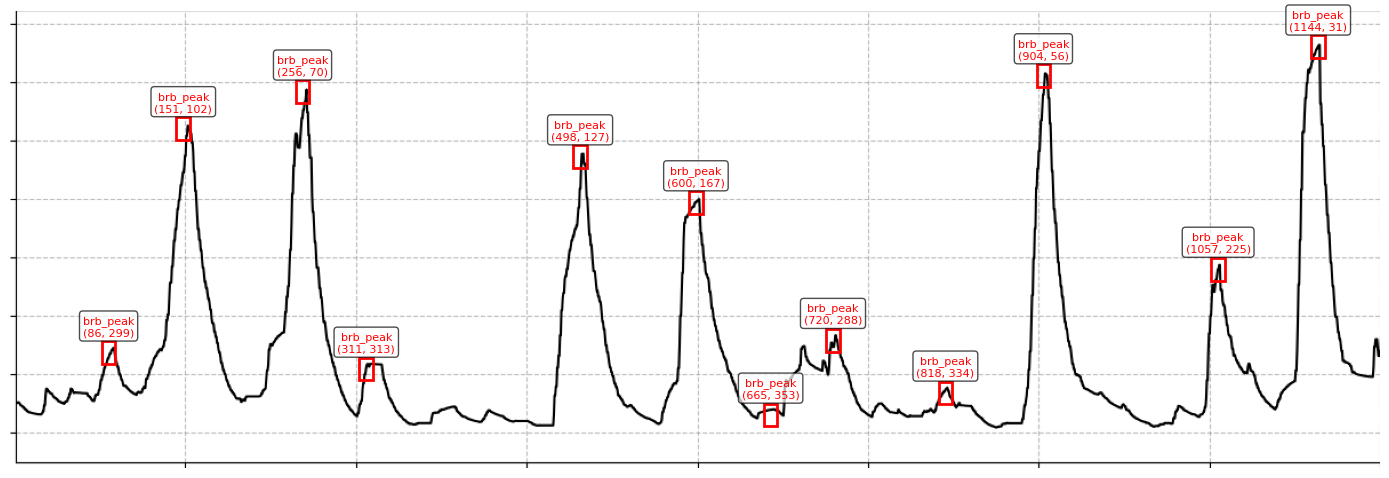

Processing windows:  18%|█▊        | 9/50 [00:02<00:12,  3.22it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0008_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0008.png
  ✓ Created 12 bounding boxes

Processing window 10/50
  Indices: 18000 to 20000
  Number of peaks in this window: 12
Actual image size: 1200x400 pixels


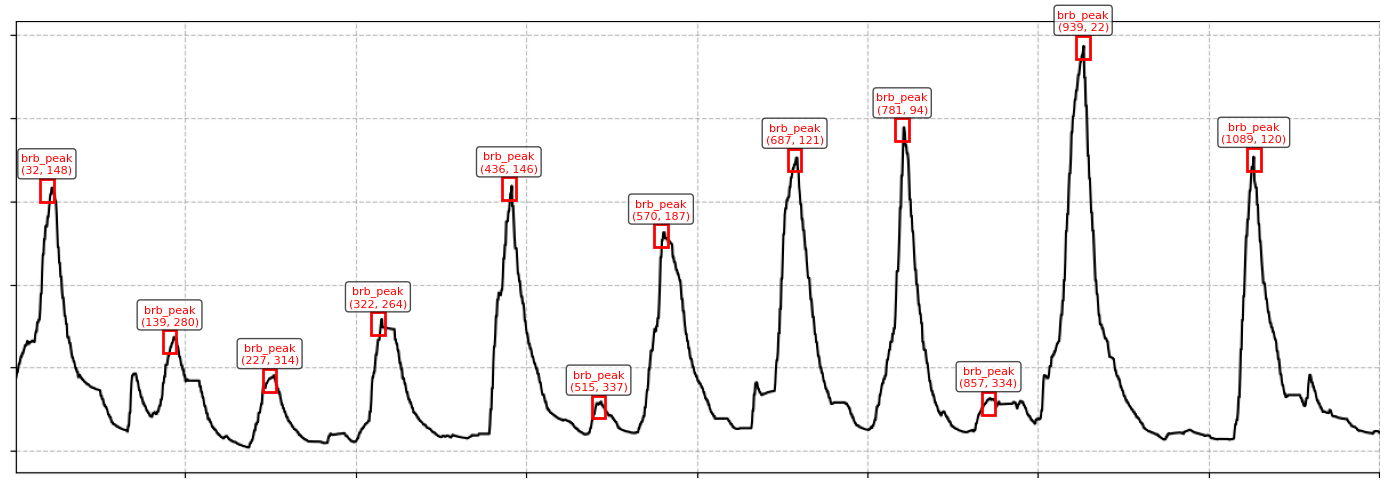

Processing windows:  20%|██        | 10/50 [00:03<00:12,  3.20it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0009_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0009.png
  ✓ Created 12 bounding boxes

Processing window 11/50
  Indices: 20000 to 22000
  Number of peaks in this window: 12
Actual image size: 1200x399 pixels


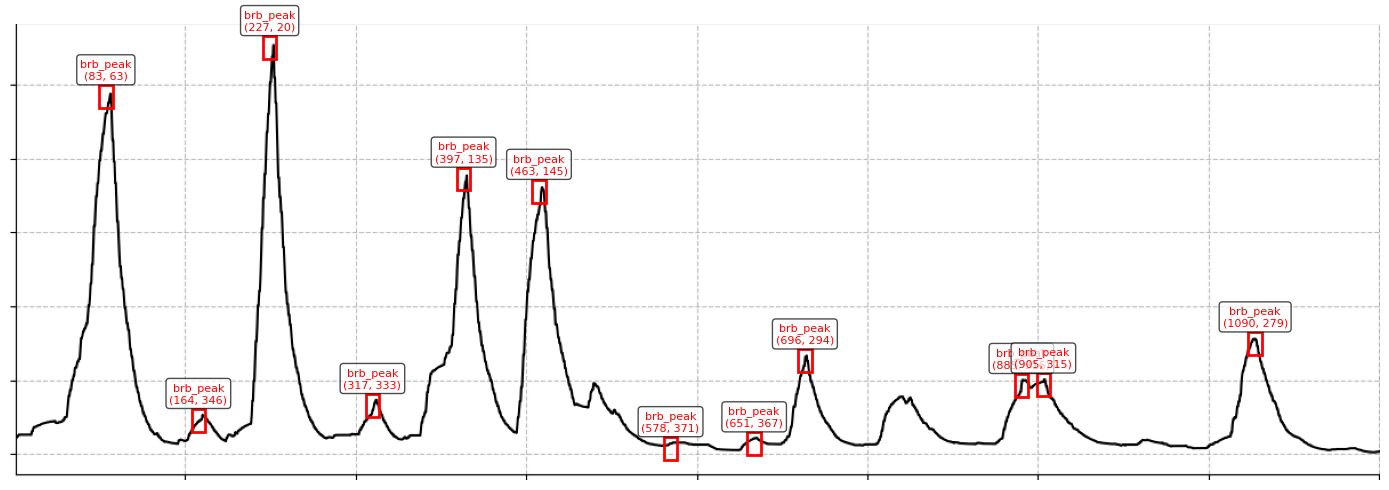

Processing windows:  22%|██▏       | 11/50 [00:03<00:12,  3.20it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0010_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0010.png
  ✓ Created 12 bounding boxes

Processing window 12/50
  Indices: 22000 to 24000
  Number of peaks in this window: 12
Actual image size: 1200x400 pixels


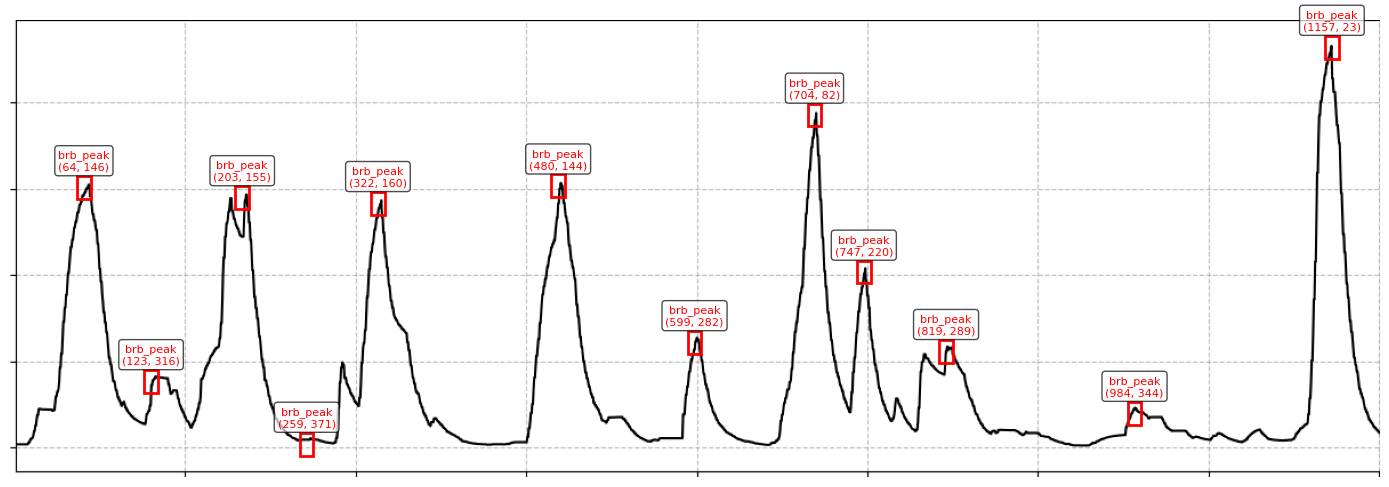

Processing windows:  24%|██▍       | 12/50 [00:03<00:11,  3.18it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0011_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0011.png
  ✓ Created 12 bounding boxes

Processing window 13/50
  Indices: 24000 to 26000
  Number of peaks in this window: 8
Actual image size: 1200x400 pixels


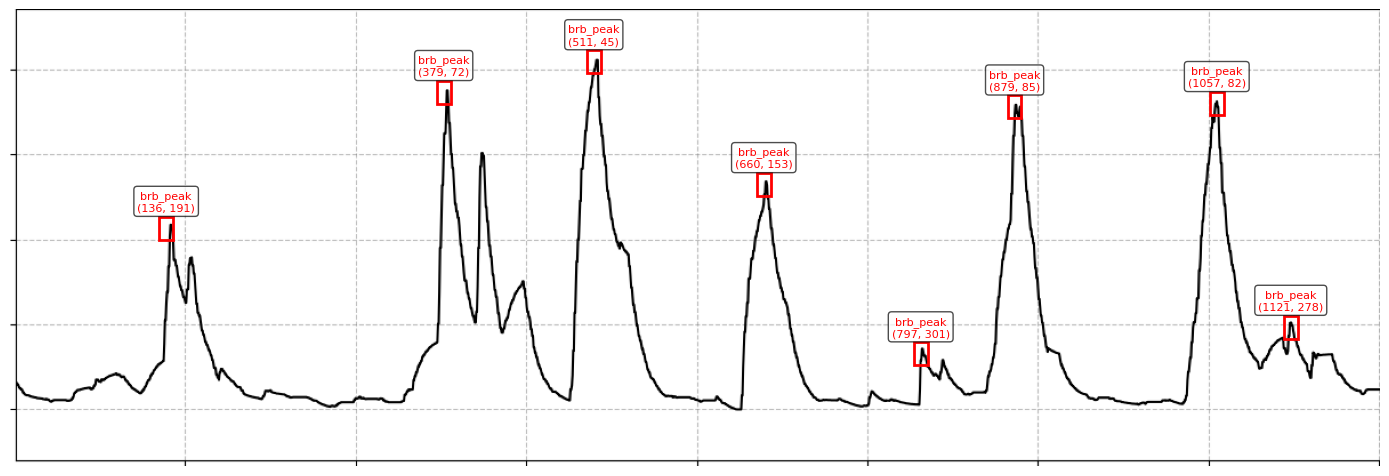

Processing windows:  26%|██▌       | 13/50 [00:04<00:11,  3.23it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0012_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0012.png
  ✓ Created 8 bounding boxes

Processing window 14/50
  Indices: 26000 to 28000
  Number of peaks in this window: 11
Actual image size: 1200x400 pixels


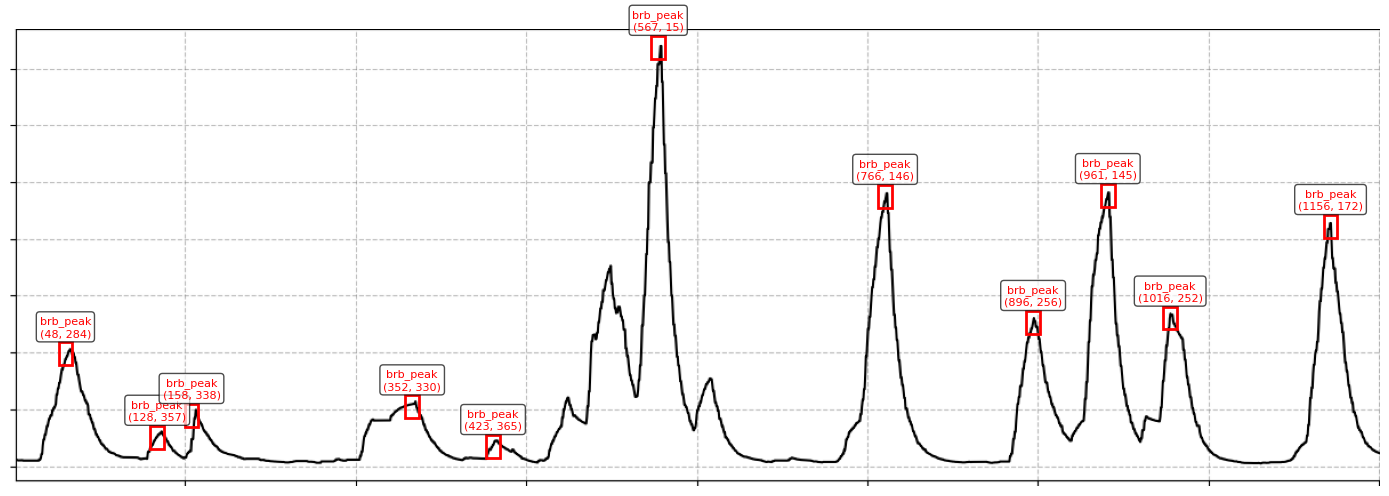

Processing windows:  28%|██▊       | 14/50 [00:04<00:11,  3.21it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0013_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0013.png
  ✓ Created 11 bounding boxes

Processing window 15/50
  Indices: 28000 to 30000
  Number of peaks in this window: 10
Actual image size: 1200x400 pixels


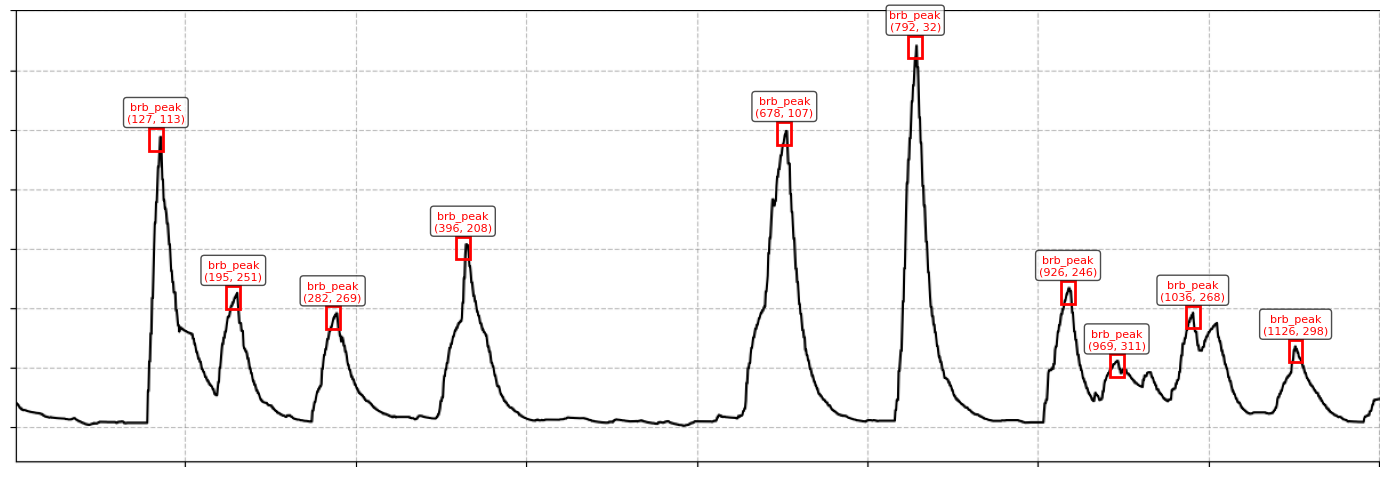

Processing windows:  30%|███       | 15/50 [00:04<00:11,  3.15it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0014_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0014.png
  ✓ Created 10 bounding boxes

Processing window 16/50
  Indices: 30000 to 32000
  Number of peaks in this window: 10
Actual image size: 1200x400 pixels


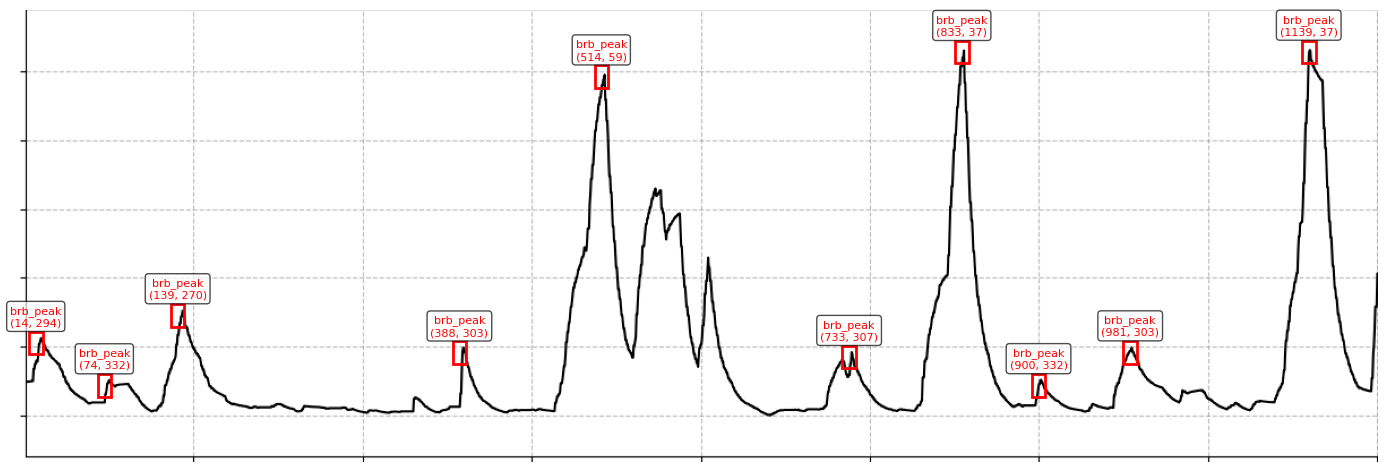

Processing windows:  32%|███▏      | 16/50 [00:04<00:10,  3.18it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0015_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0015.png
  ✓ Created 10 bounding boxes

Processing window 17/50
  Indices: 32000 to 34000
  Number of peaks in this window: 11
Actual image size: 1200x400 pixels


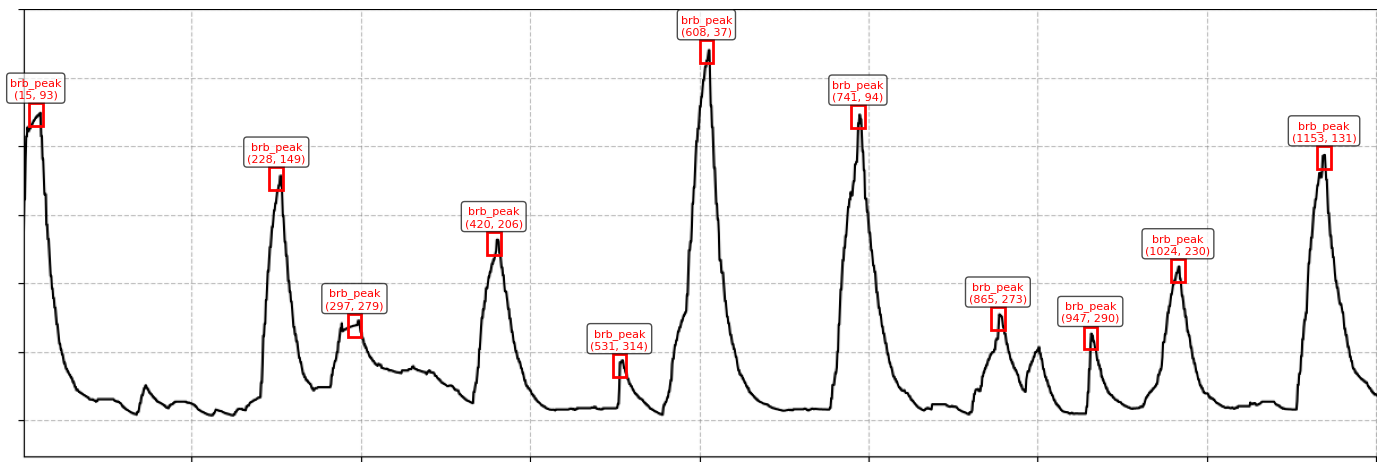

Processing windows:  34%|███▍      | 17/50 [00:05<00:11,  2.91it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0016_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0016.png
  ✓ Created 11 bounding boxes

Processing window 18/50
  Indices: 34000 to 36000
  Number of peaks in this window: 12
Actual image size: 1200x400 pixels


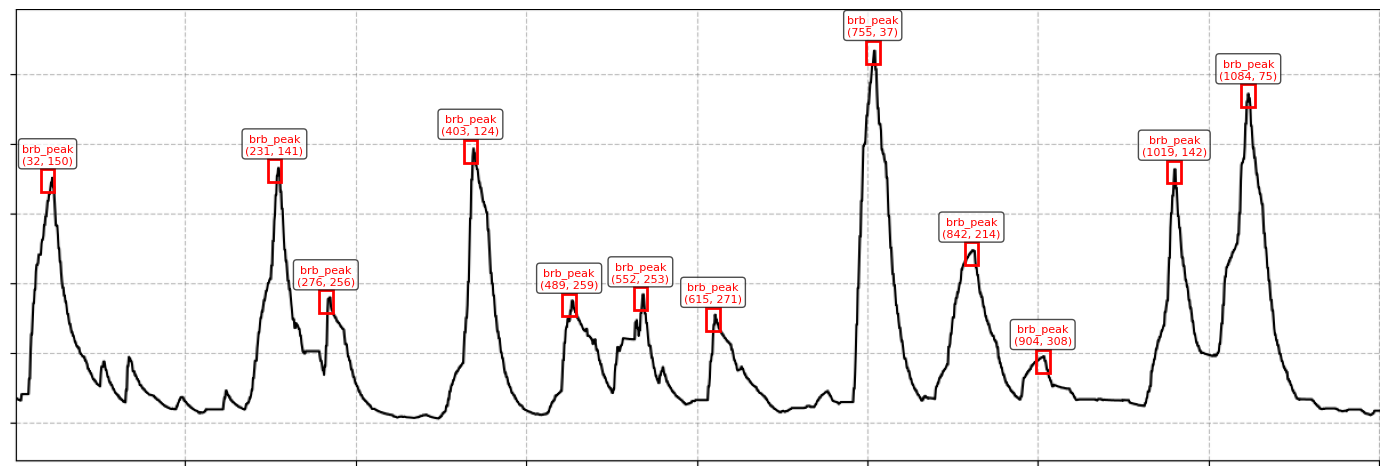

Processing windows:  36%|███▌      | 18/50 [00:05<00:10,  2.98it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0017_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0017.png
  ✓ Created 12 bounding boxes

Processing window 19/50
  Indices: 36000 to 38000
  Number of peaks in this window: 10
Actual image size: 1200x400 pixels


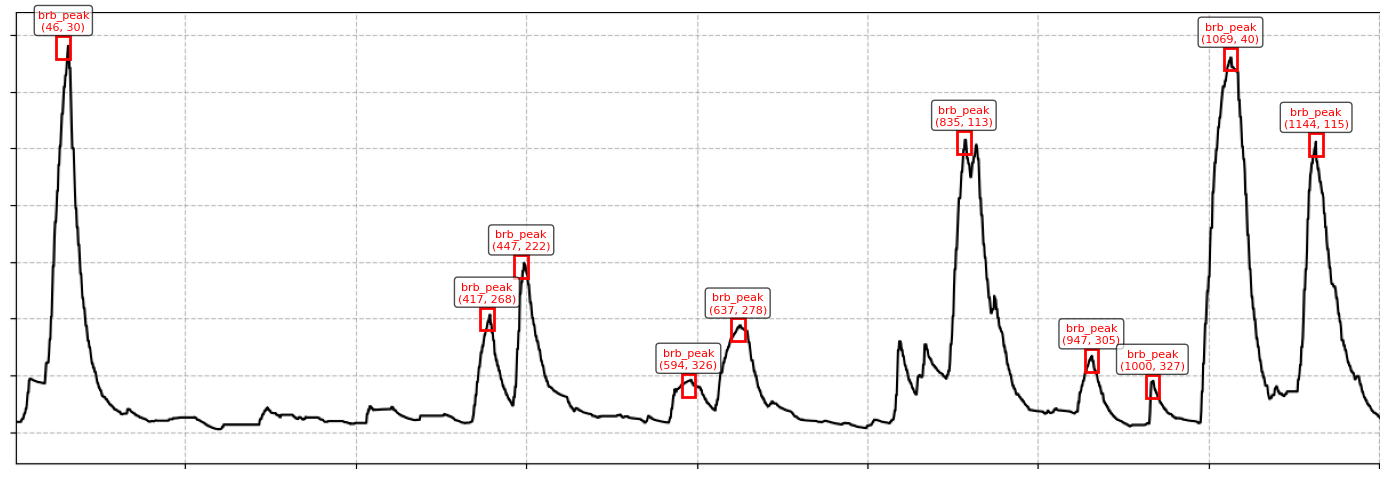

Processing windows:  38%|███▊      | 19/50 [00:05<00:10,  3.06it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0018_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0018.png
  ✓ Created 10 bounding boxes

Processing window 20/50
  Indices: 38000 to 40000
  Number of peaks in this window: 12
Actual image size: 1200x400 pixels


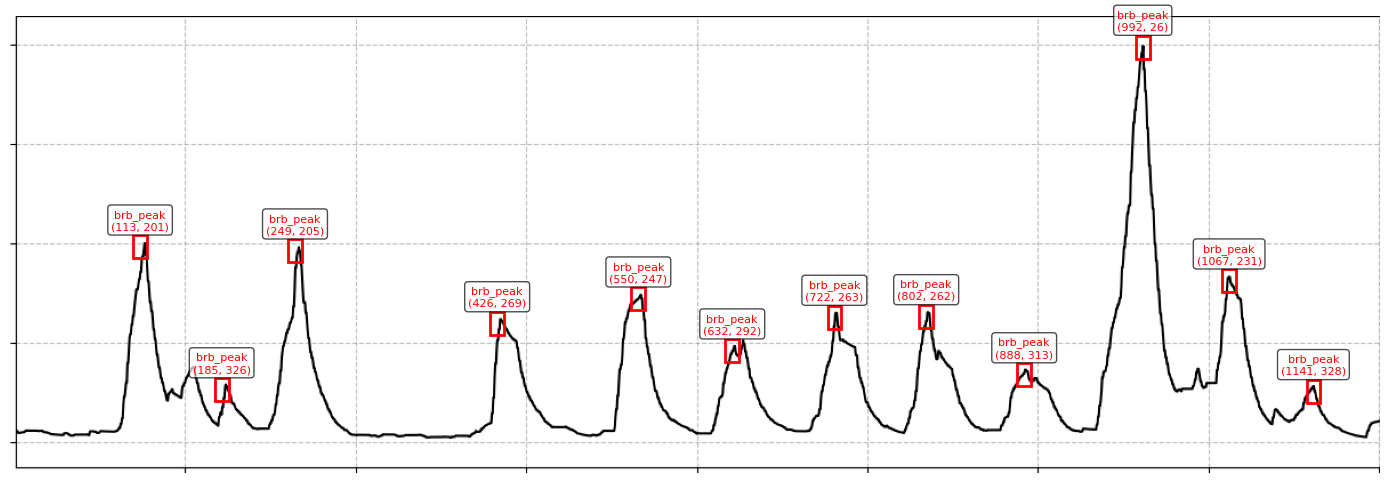

Processing windows:  40%|████      | 20/50 [00:06<00:09,  3.07it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0019_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0019.png
  ✓ Created 12 bounding boxes

Processing window 21/50
  Indices: 40000 to 42000
  Number of peaks in this window: 9
Actual image size: 1200x400 pixels


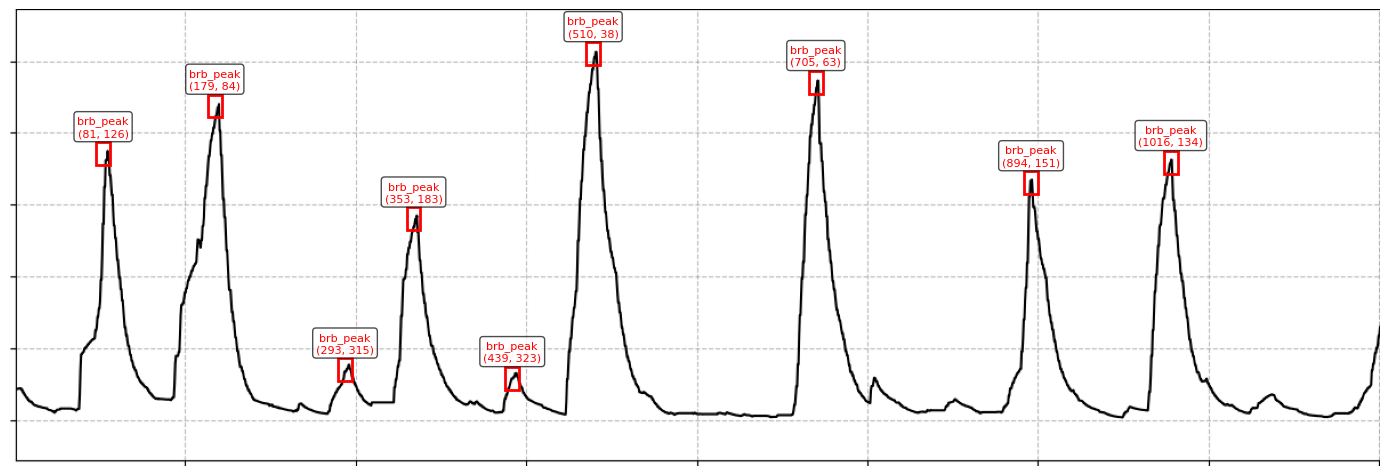

Processing windows:  42%|████▏     | 21/50 [00:06<00:09,  3.13it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0020_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0020.png
  ✓ Created 9 bounding boxes

Processing window 22/50
  Indices: 42000 to 44000
  Number of peaks in this window: 8
Actual image size: 1200x400 pixels


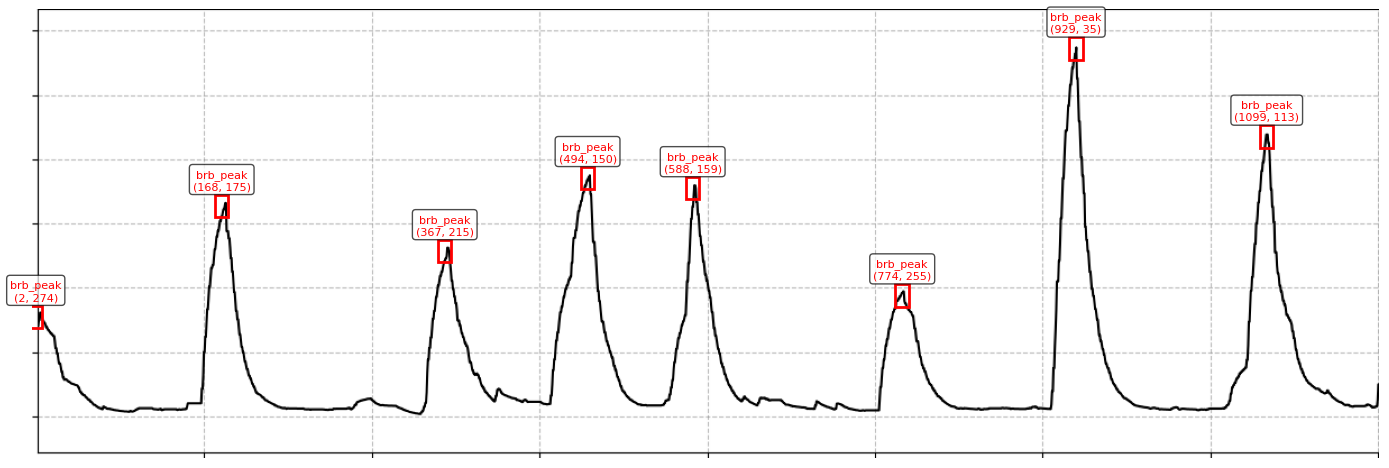

Processing windows:  44%|████▍     | 22/50 [00:06<00:08,  3.20it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0021_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0021.png
  ✓ Created 8 bounding boxes

Processing window 23/50
  Indices: 44000 to 46000
  Number of peaks in this window: 10
Actual image size: 1200x400 pixels


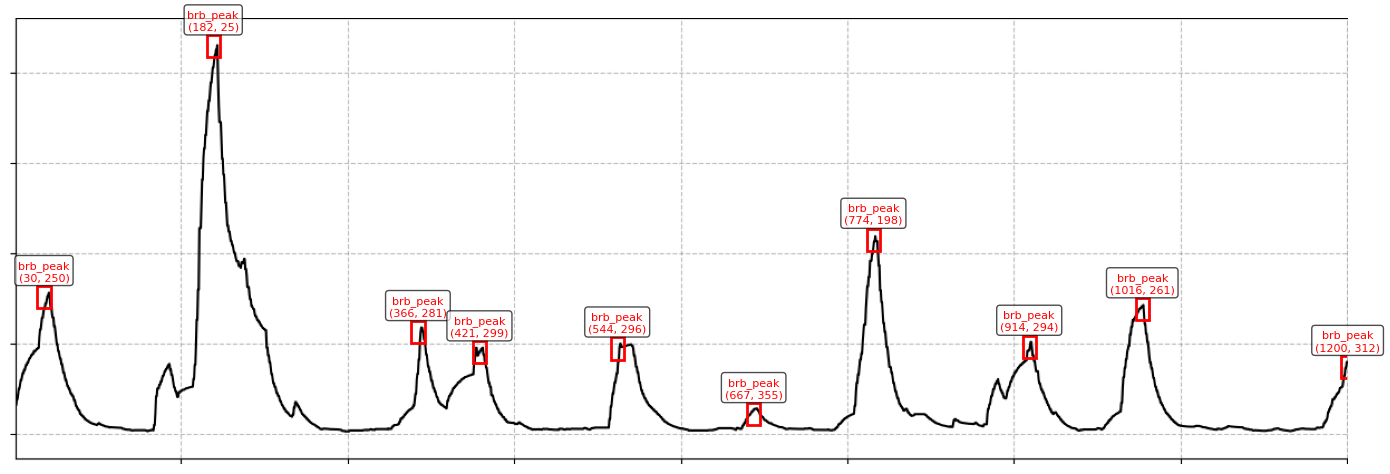

Processing windows:  46%|████▌     | 23/50 [00:07<00:08,  3.25it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0022_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0022.png
  ✓ Created 10 bounding boxes

Processing window 24/50
  Indices: 46000 to 48000
  Number of peaks in this window: 8
Actual image size: 1200x400 pixels


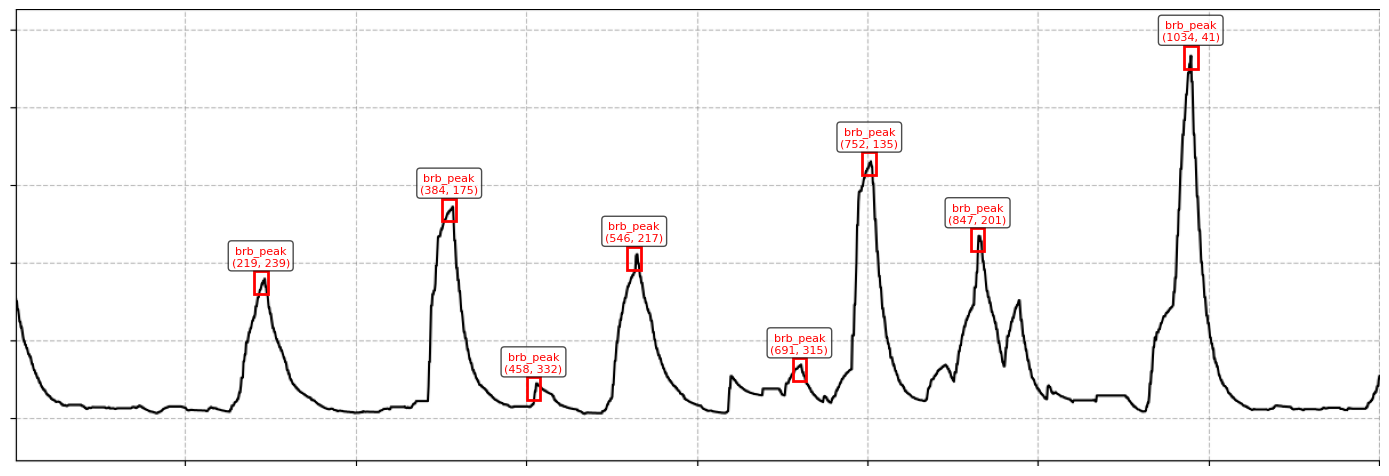

Processing windows:  48%|████▊     | 24/50 [00:07<00:07,  3.28it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0023_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0023.png
  ✓ Created 8 bounding boxes

Processing window 25/50
  Indices: 48000 to 50000
  Number of peaks in this window: 8
Actual image size: 1200x400 pixels


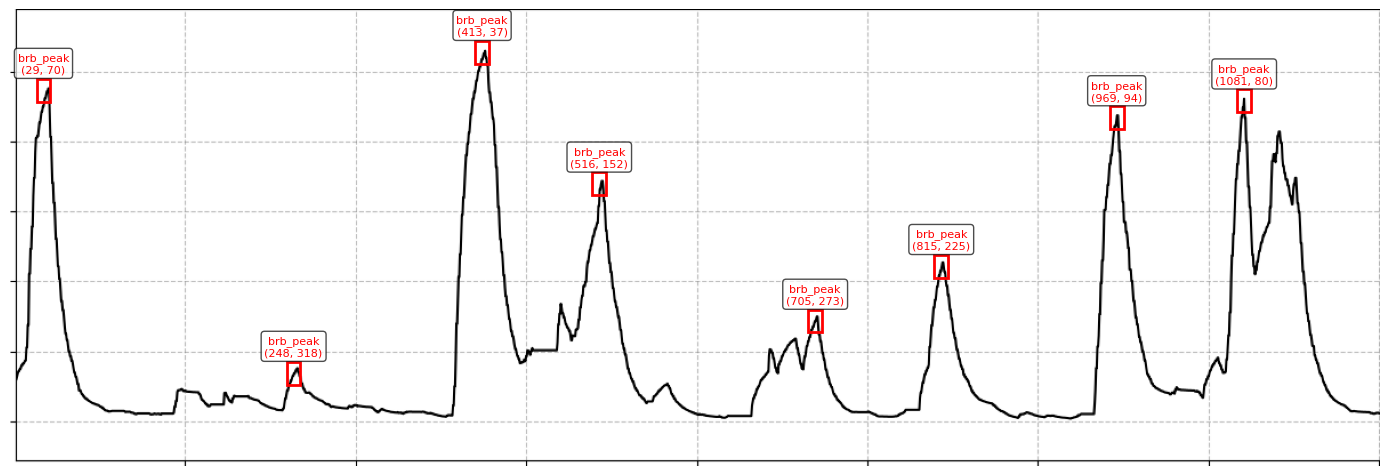

Processing windows:  50%|█████     | 25/50 [00:07<00:07,  3.30it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0024_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0024.png
  ✓ Created 8 bounding boxes

Processing window 26/50
  Indices: 50000 to 52000
  Number of peaks in this window: 8
Actual image size: 1199x400 pixels


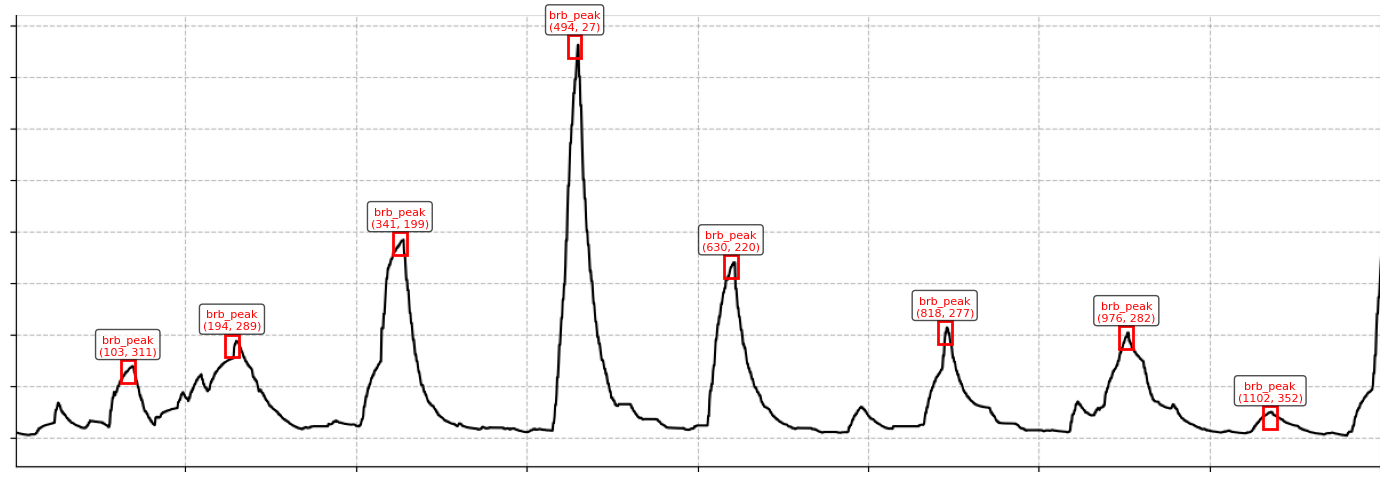

Processing windows:  52%|█████▏    | 26/50 [00:08<00:07,  3.30it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0025_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0025.png
  ✓ Created 8 bounding boxes

Processing window 27/50
  Indices: 52000 to 54000
  Number of peaks in this window: 9
Actual image size: 1200x399 pixels


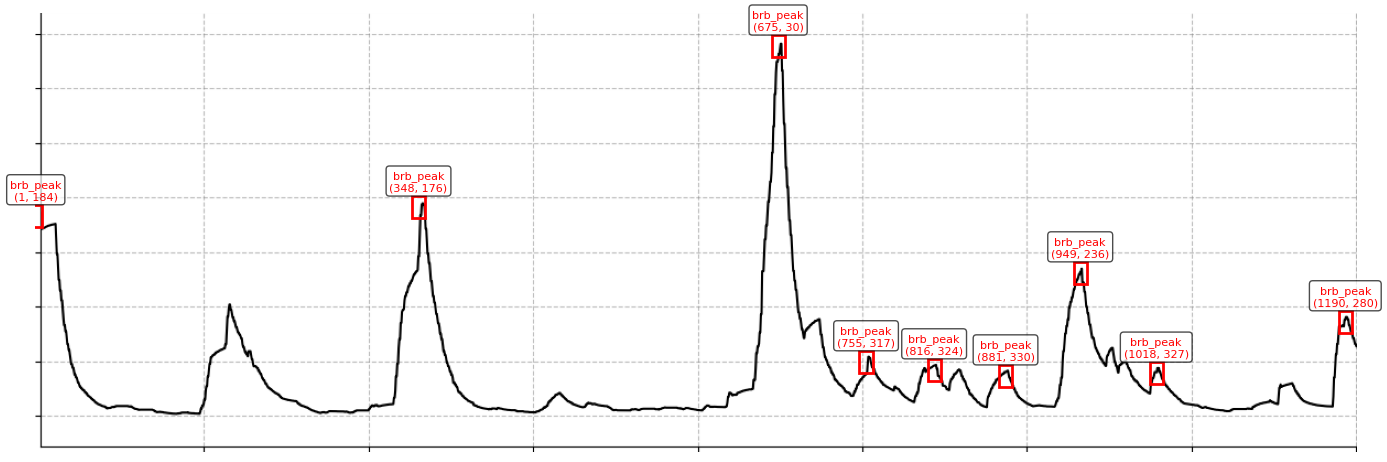

Processing windows:  54%|█████▍    | 27/50 [00:08<00:06,  3.32it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0026_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0026.png
  ✓ Created 9 bounding boxes

Processing window 28/50
  Indices: 54000 to 56000
  Number of peaks in this window: 9
Actual image size: 1200x400 pixels


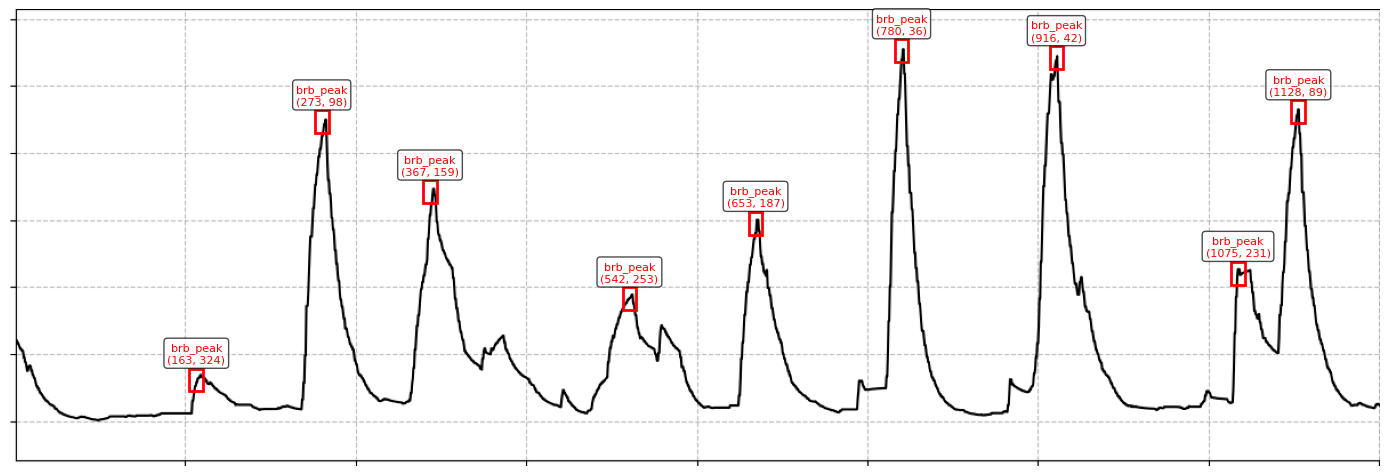

Processing windows:  56%|█████▌    | 28/50 [00:08<00:06,  3.31it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0027_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0027.png
  ✓ Created 9 bounding boxes

Processing window 29/50
  Indices: 56000 to 58000
  Number of peaks in this window: 8
Actual image size: 1200x400 pixels


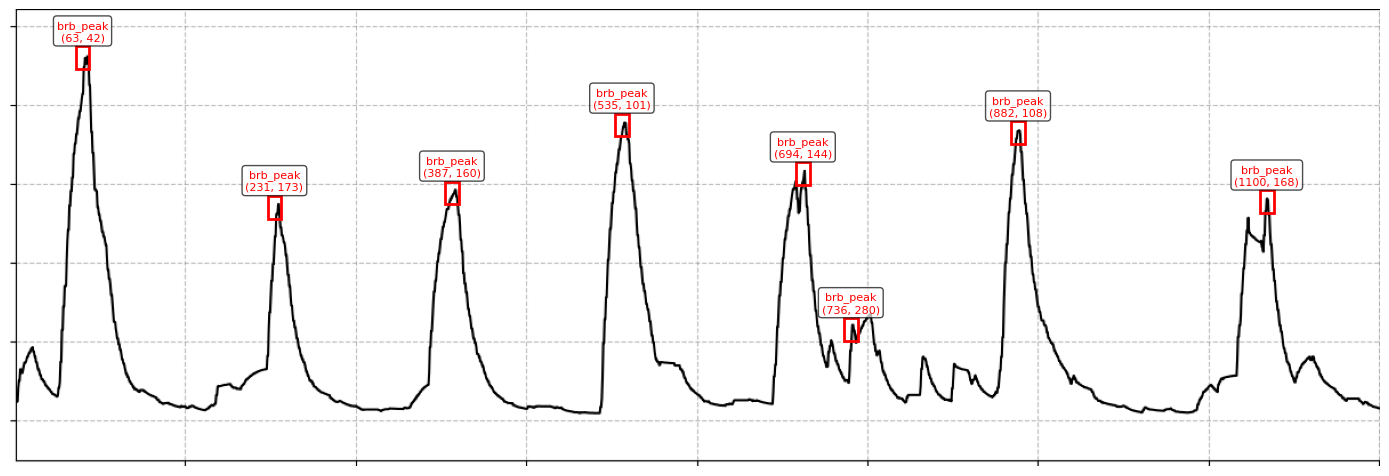

Processing windows:  58%|█████▊    | 29/50 [00:09<00:06,  3.32it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0028_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0028.png
  ✓ Created 8 bounding boxes

Processing window 30/50
  Indices: 58000 to 60000
  Number of peaks in this window: 7
Actual image size: 1200x400 pixels


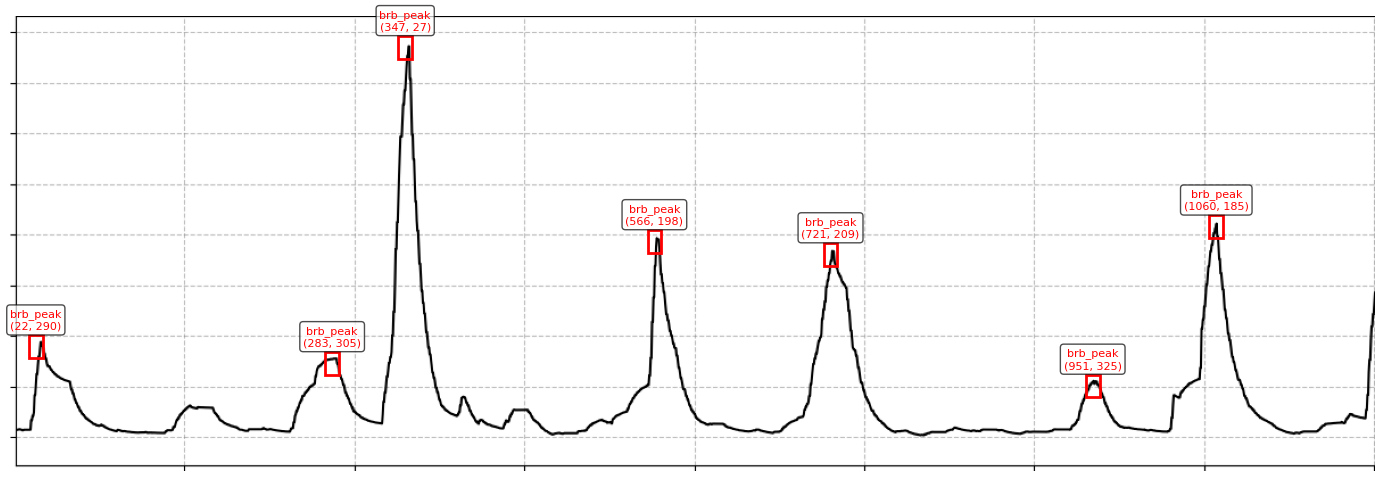

Processing windows:  60%|██████    | 30/50 [00:09<00:06,  3.32it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0029_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0029.png
  ✓ Created 7 bounding boxes

Processing window 31/50
  Indices: 60000 to 62000
  Number of peaks in this window: 8
Actual image size: 1200x400 pixels


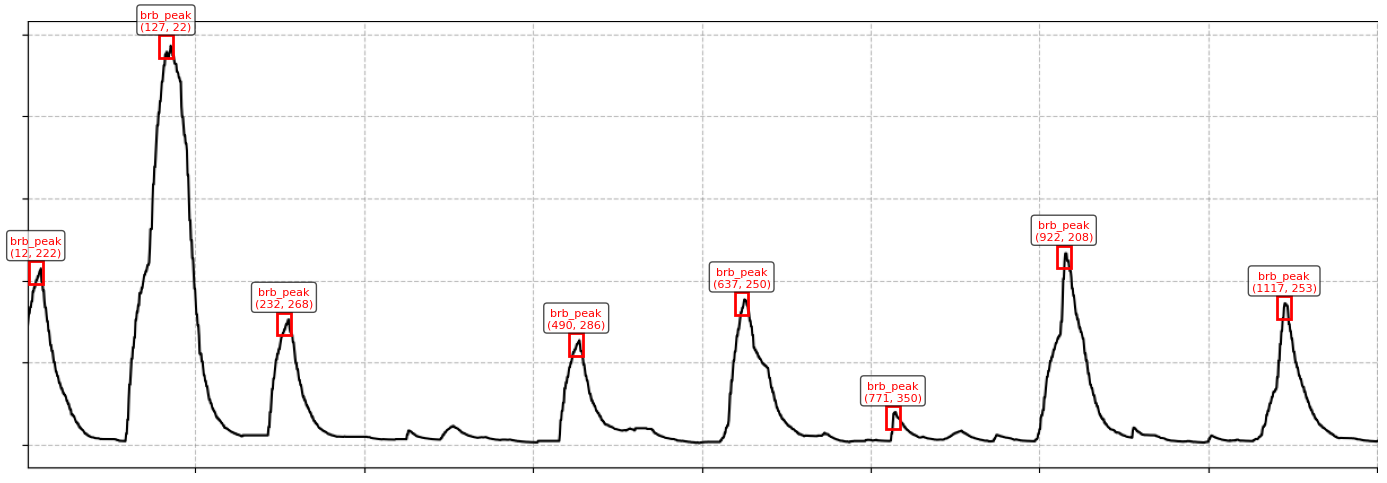

Processing windows:  62%|██████▏   | 31/50 [00:09<00:06,  3.11it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0030_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0030.png
  ✓ Created 8 bounding boxes

Processing window 32/50
  Indices: 62000 to 64000
  Number of peaks in this window: 8
Actual image size: 1200x400 pixels


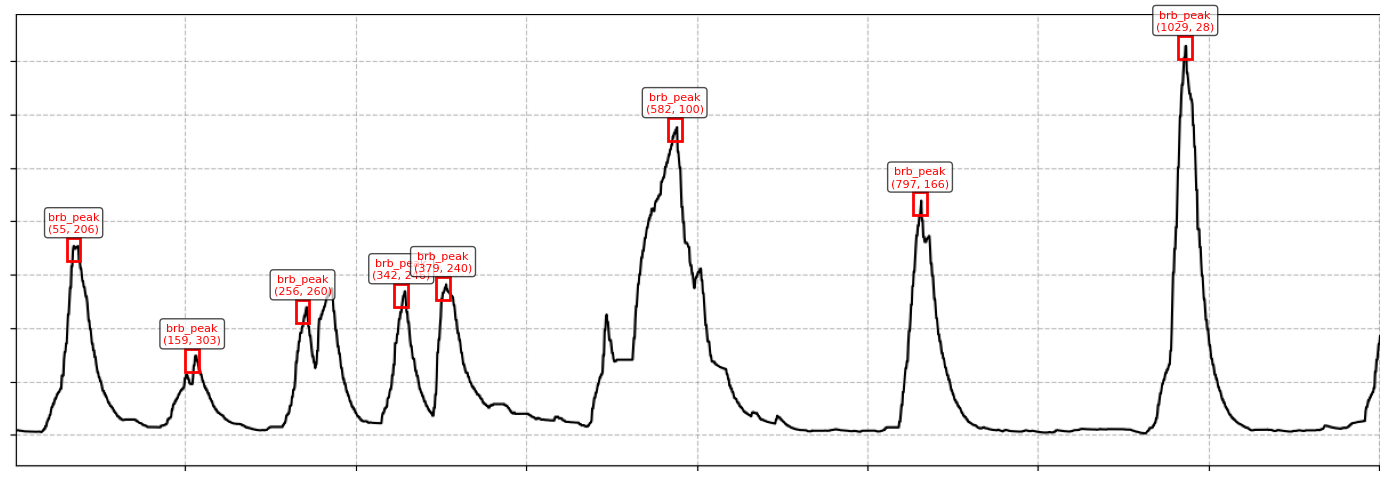

Processing windows:  64%|██████▍   | 32/50 [00:09<00:05,  3.15it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0031_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0031.png
  ✓ Created 8 bounding boxes

Processing window 33/50
  Indices: 64000 to 66000
  Number of peaks in this window: 9
Actual image size: 1200x400 pixels


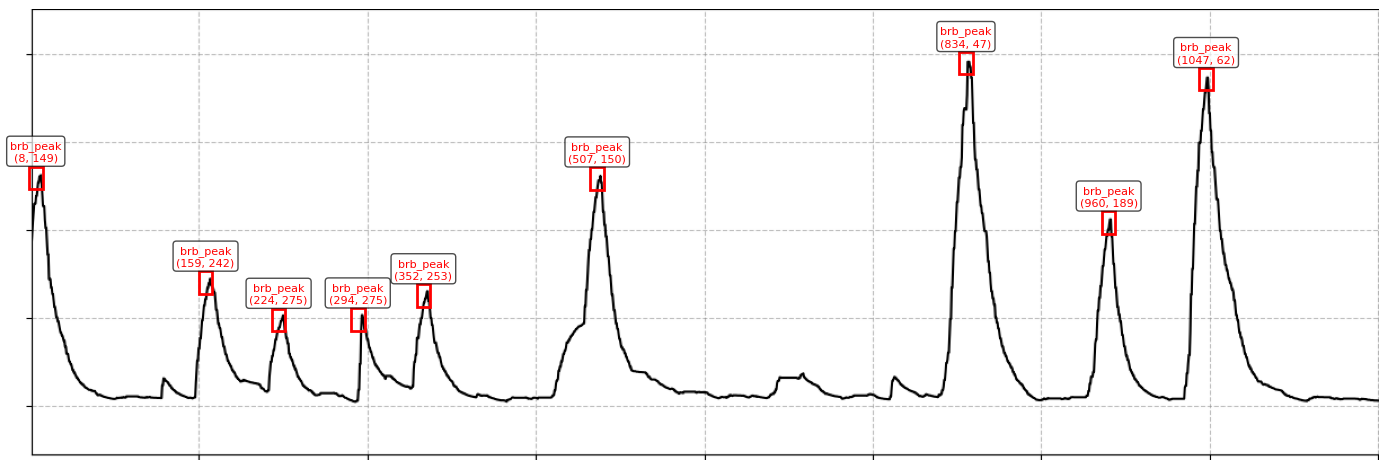

Processing windows:  66%|██████▌   | 33/50 [00:10<00:05,  3.22it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0032_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0032.png
  ✓ Created 9 bounding boxes

Processing window 34/50
  Indices: 66000 to 68000
  Number of peaks in this window: 9
Actual image size: 1200x400 pixels


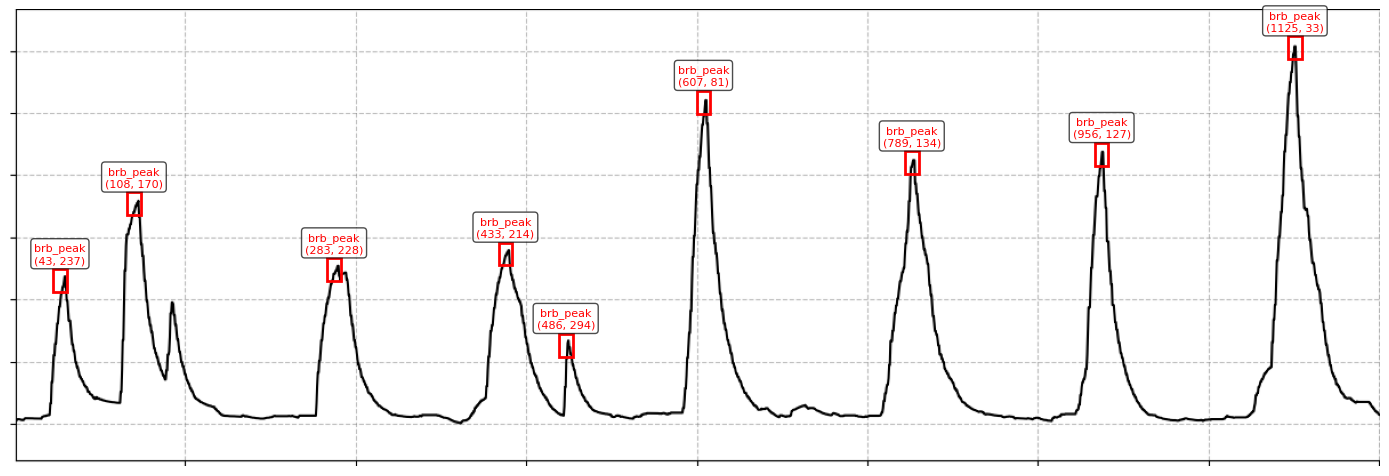

Processing windows:  68%|██████▊   | 34/50 [00:10<00:04,  3.23it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0033_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0033.png
  ✓ Created 9 bounding boxes

Processing window 35/50
  Indices: 68000 to 70000
  Number of peaks in this window: 10
Actual image size: 1200x400 pixels


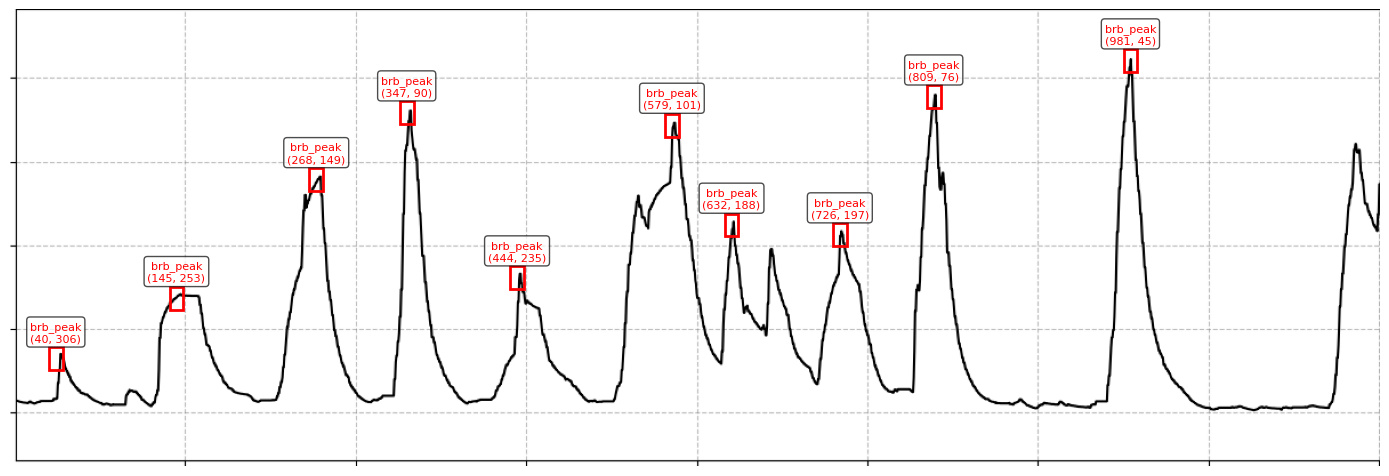

Processing windows:  70%|███████   | 35/50 [00:10<00:04,  3.26it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0034_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0034.png
  ✓ Created 10 bounding boxes

Processing window 36/50
  Indices: 70000 to 72000
  Number of peaks in this window: 6
Actual image size: 1200x400 pixels


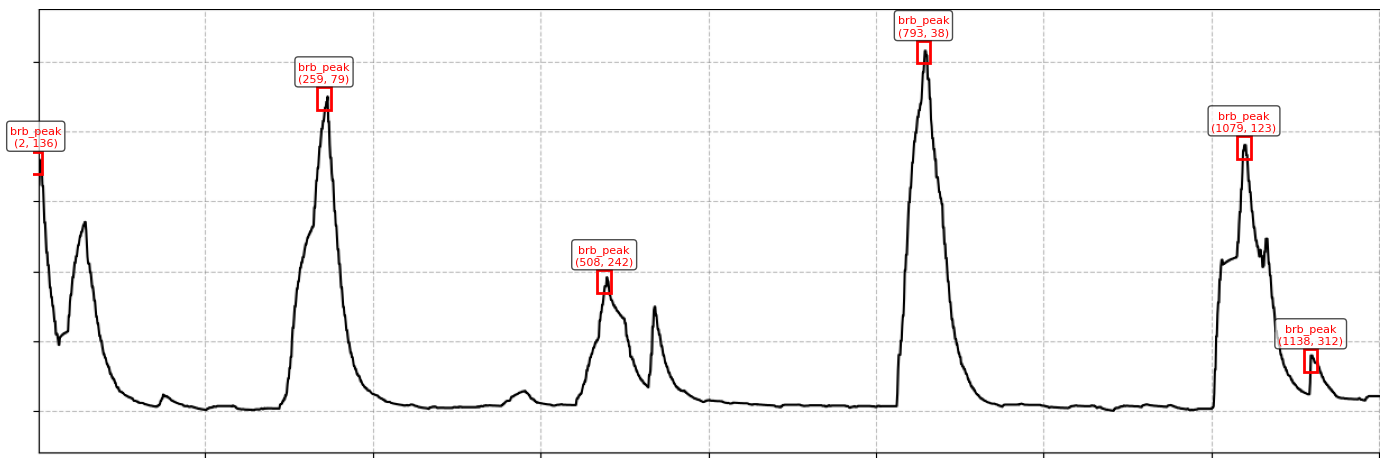

Processing windows:  72%|███████▏  | 36/50 [00:11<00:04,  3.34it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0035_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0035.png
  ✓ Created 6 bounding boxes

Processing window 37/50
  Indices: 72000 to 74000
  Number of peaks in this window: 10
Actual image size: 1200x400 pixels


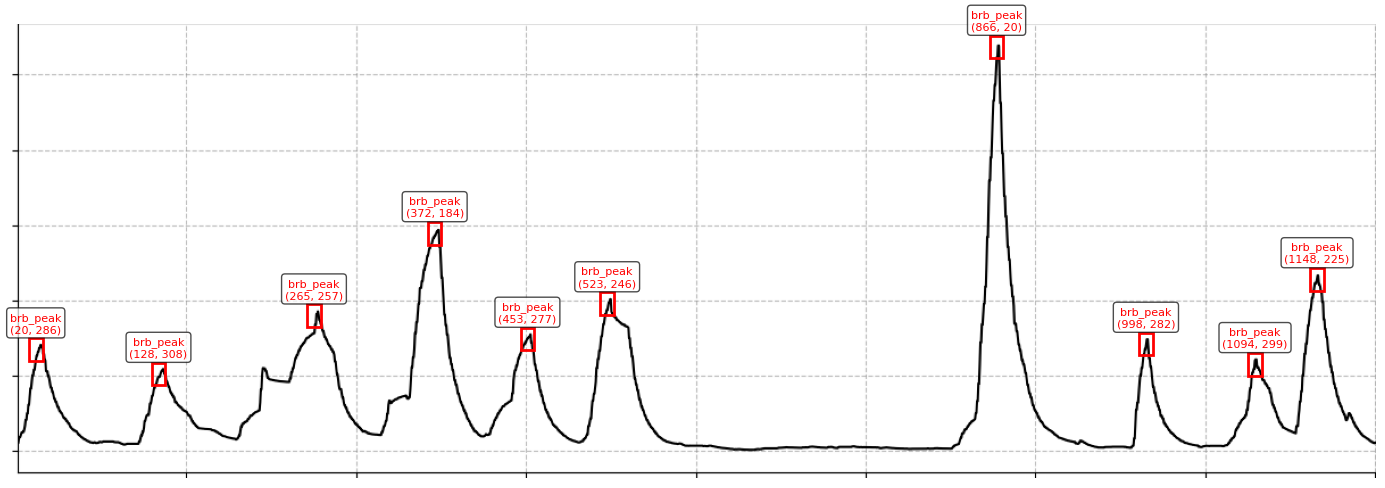

Processing windows:  74%|███████▍  | 37/50 [00:11<00:03,  3.32it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0036_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0036.png
  ✓ Created 10 bounding boxes

Processing window 38/50
  Indices: 74000 to 76000
  Number of peaks in this window: 7
Actual image size: 1200x400 pixels


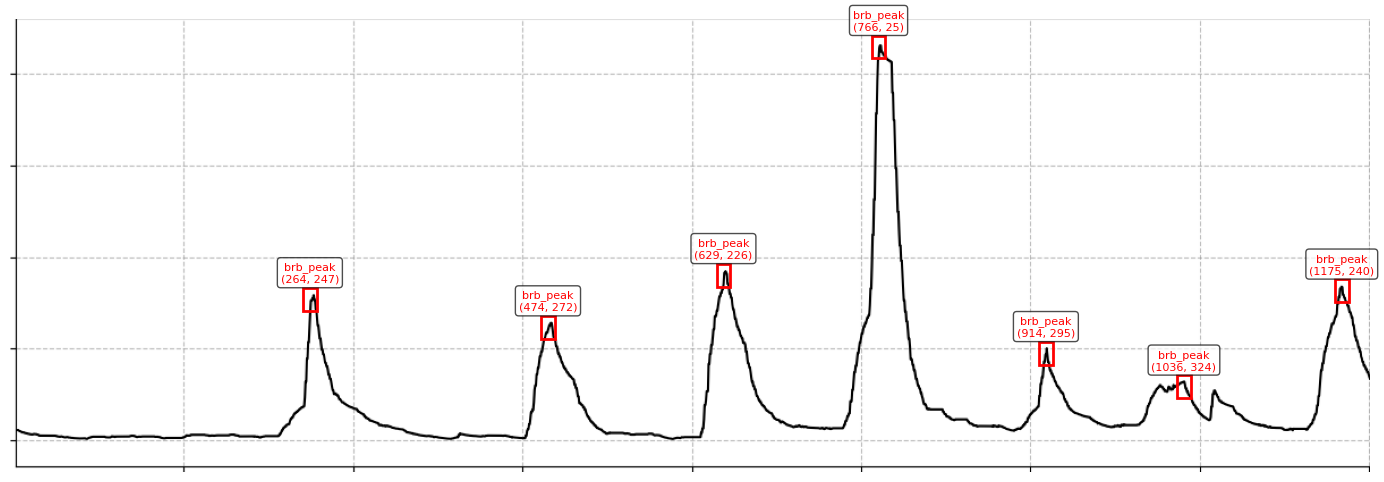

Processing windows:  76%|███████▌  | 38/50 [00:11<00:03,  3.35it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0037_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0037.png
  ✓ Created 7 bounding boxes

Processing window 39/50
  Indices: 76000 to 78000
  Number of peaks in this window: 10
Actual image size: 1200x400 pixels


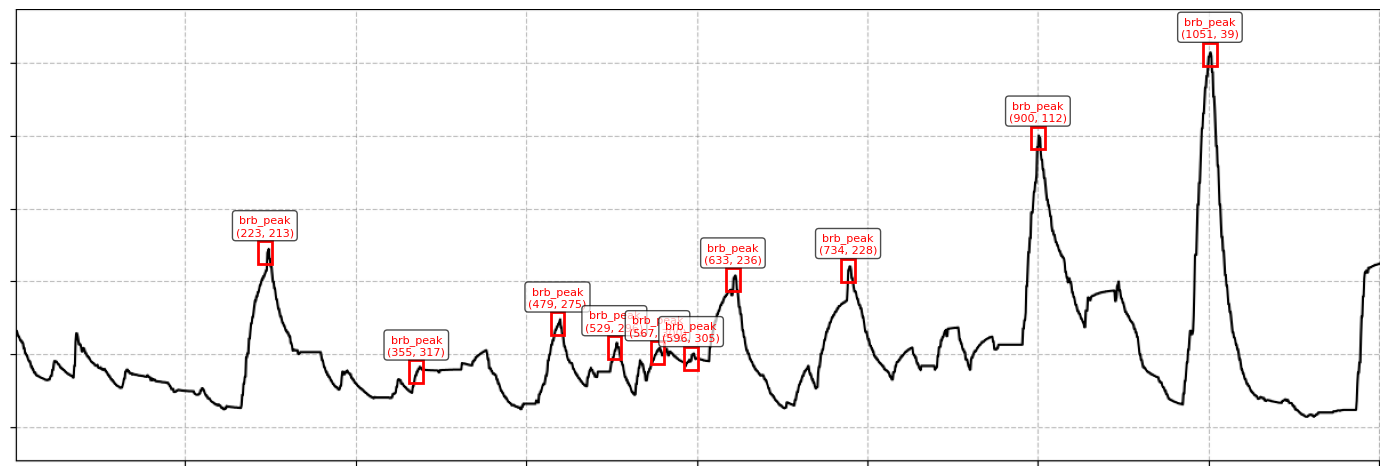

Processing windows:  78%|███████▊  | 39/50 [00:12<00:03,  3.33it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0038_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0038.png
  ✓ Created 10 bounding boxes

Processing window 40/50
  Indices: 78000 to 80000
  Number of peaks in this window: 9
Actual image size: 1200x400 pixels


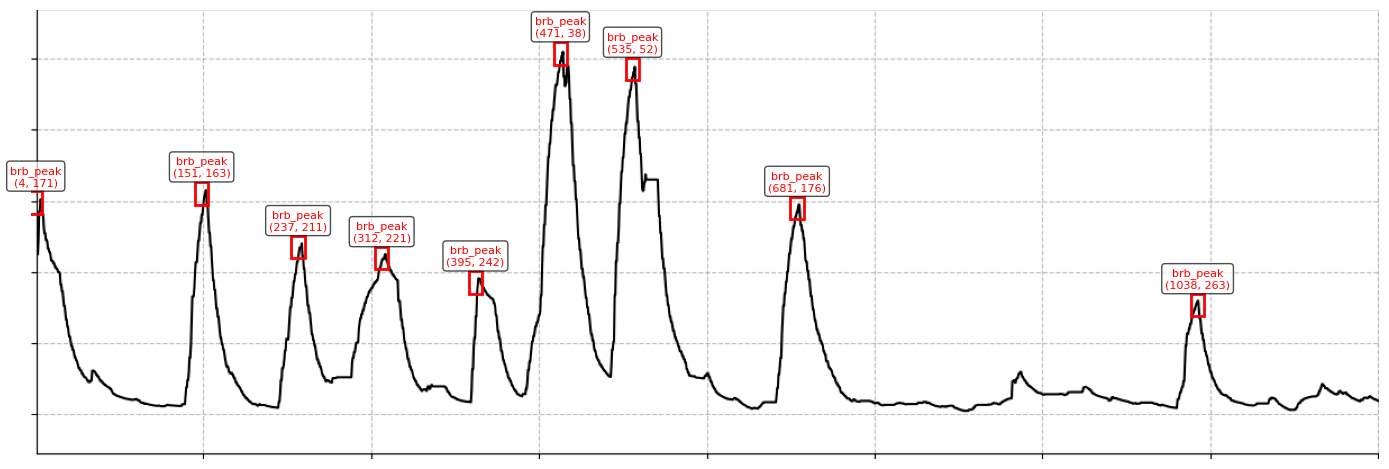

Processing windows:  80%|████████  | 40/50 [00:12<00:03,  3.32it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0039_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0039.png
  ✓ Created 9 bounding boxes

Processing window 41/50
  Indices: 80000 to 82000
  Number of peaks in this window: 9
Actual image size: 1200x400 pixels


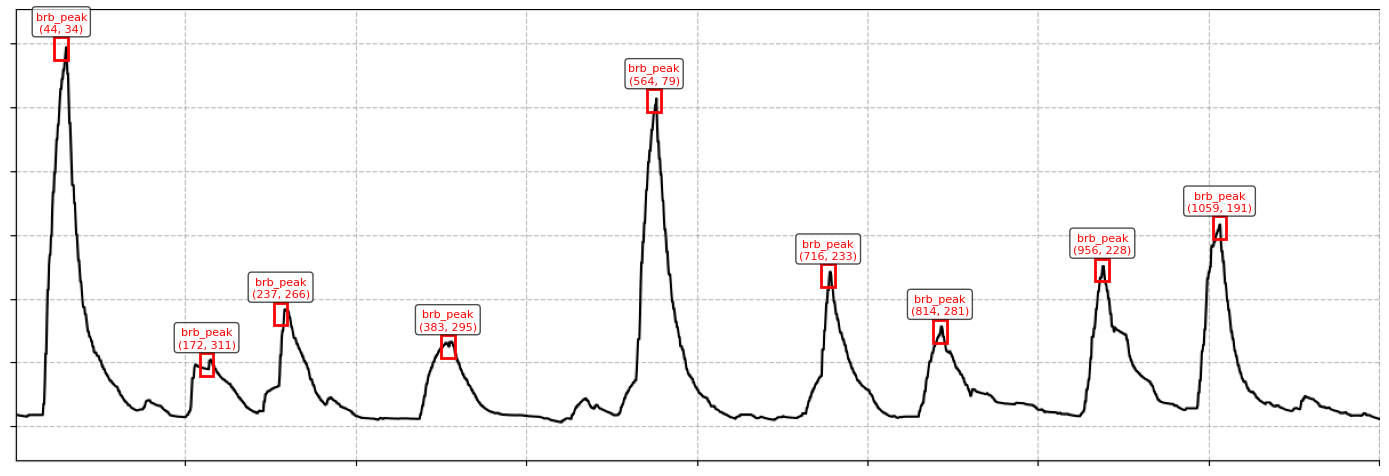

Processing windows:  82%|████████▏ | 41/50 [00:12<00:02,  3.32it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0040_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0040.png
  ✓ Created 9 bounding boxes

Processing window 42/50
  Indices: 82000 to 84000
  Number of peaks in this window: 10
Actual image size: 1200x400 pixels


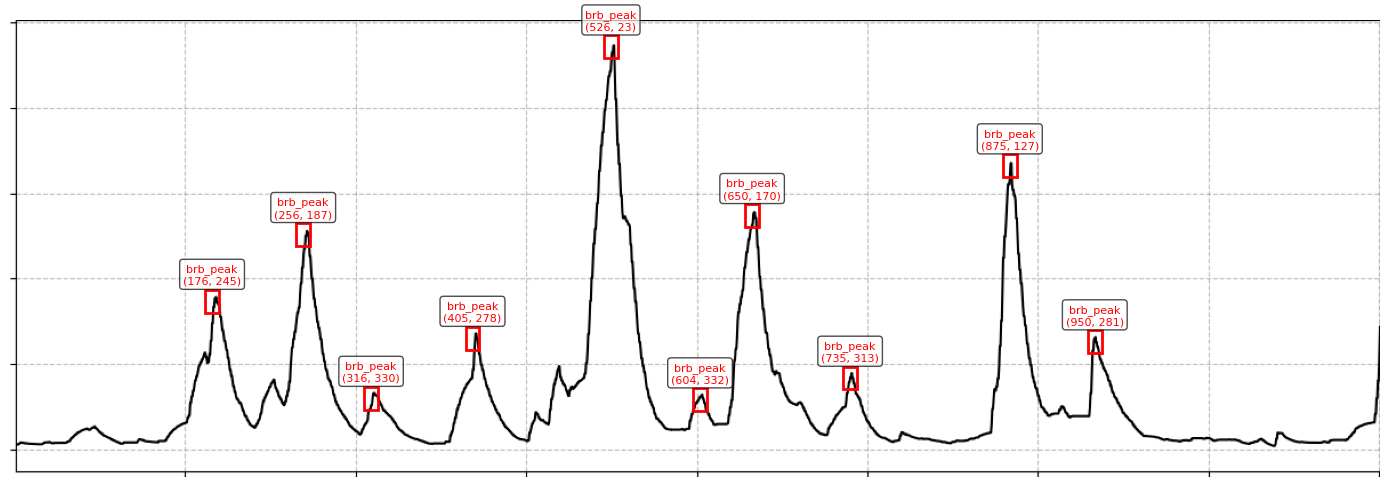

Processing windows:  84%|████████▍ | 42/50 [00:12<00:02,  3.30it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0041_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0041.png
  ✓ Created 10 bounding boxes

Processing window 43/50
  Indices: 84000 to 86000
  Number of peaks in this window: 8
Actual image size: 1200x400 pixels


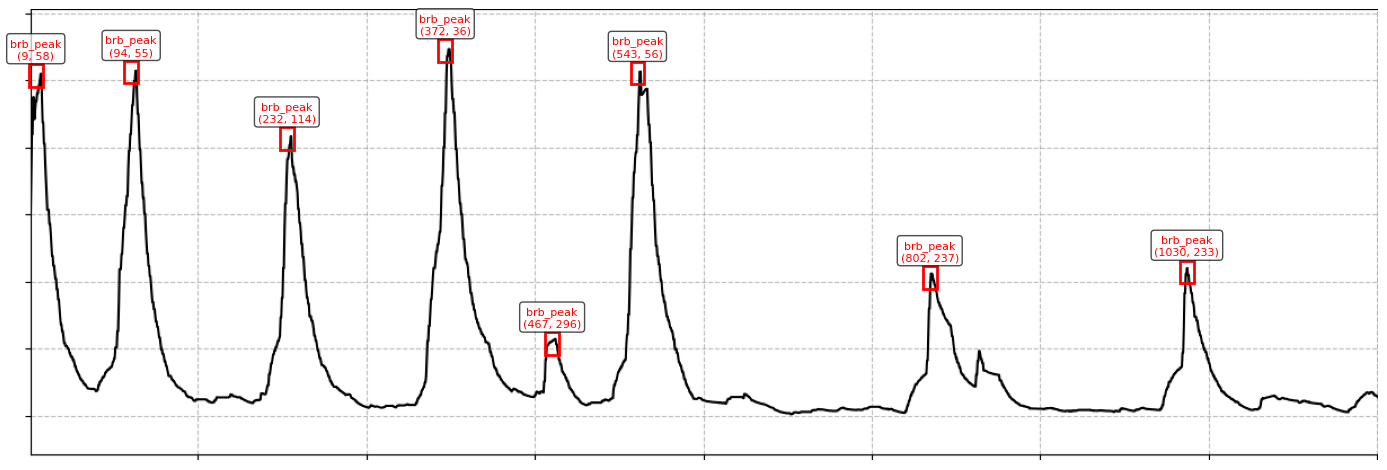

Processing windows:  86%|████████▌ | 43/50 [00:13<00:02,  3.33it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0042_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0042.png
  ✓ Created 8 bounding boxes

Processing window 44/50
  Indices: 86000 to 88000
  Number of peaks in this window: 7
Actual image size: 1200x400 pixels


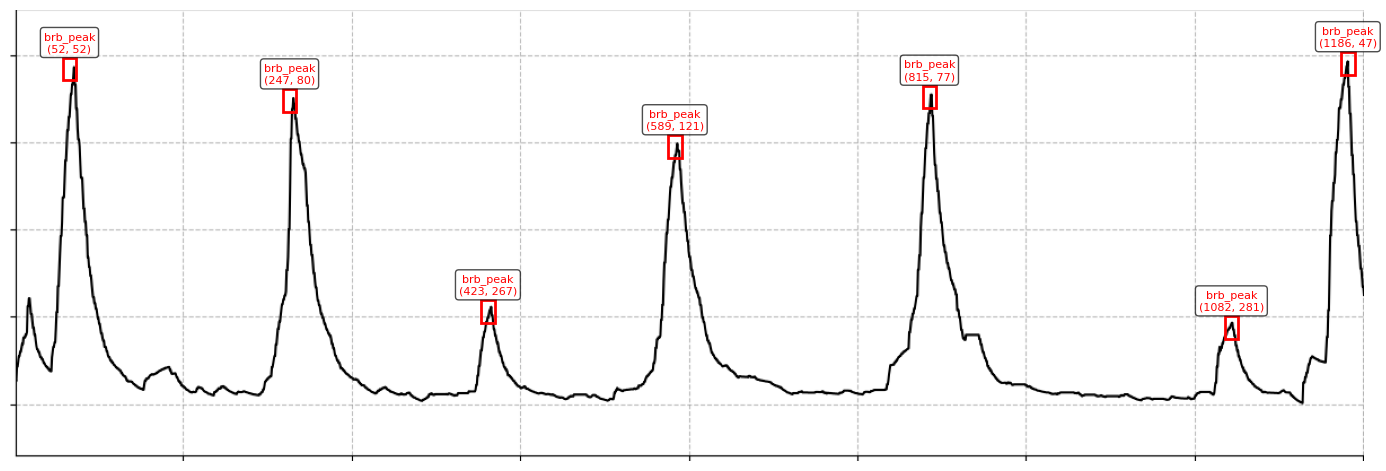

Processing windows:  88%|████████▊ | 44/50 [00:13<00:01,  3.37it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0043_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0043.png
  ✓ Created 7 bounding boxes

Processing window 45/50
  Indices: 88000 to 90000
  Number of peaks in this window: 11
Actual image size: 1200x400 pixels


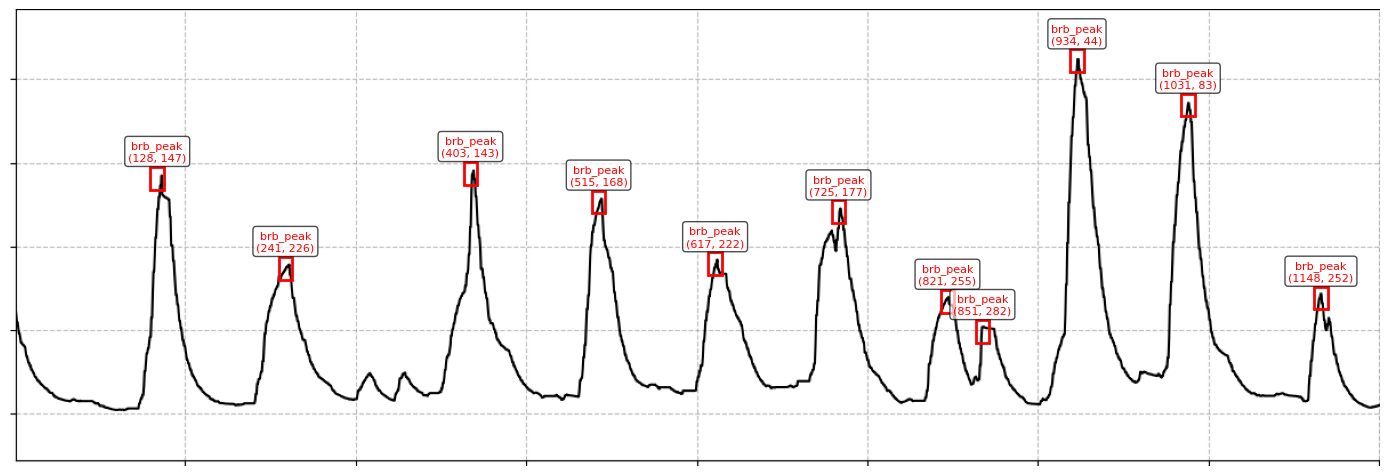

Processing windows:  90%|█████████ | 45/50 [00:13<00:01,  3.33it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0044_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0044.png
  ✓ Created 11 bounding boxes

Processing window 46/50
  Indices: 90000 to 92000
  Number of peaks in this window: 10
Actual image size: 1200x399 pixels


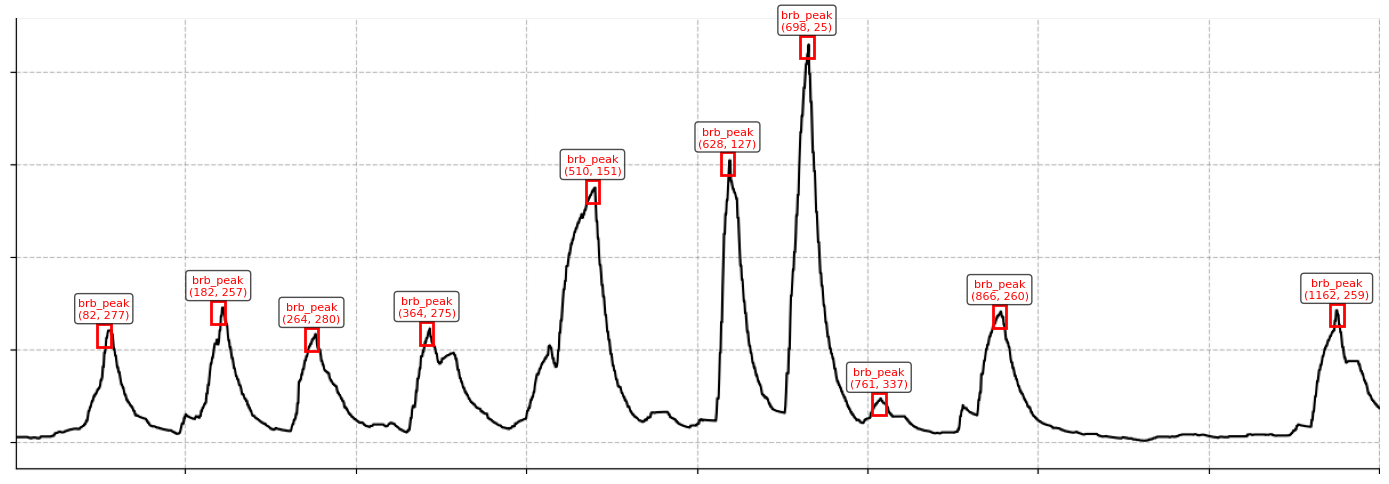

Processing windows:  92%|█████████▏| 46/50 [00:14<00:01,  3.07it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0045_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0045.png
  ✓ Created 10 bounding boxes

Processing window 47/50
  Indices: 92000 to 94000
  Number of peaks in this window: 7
Actual image size: 1200x400 pixels


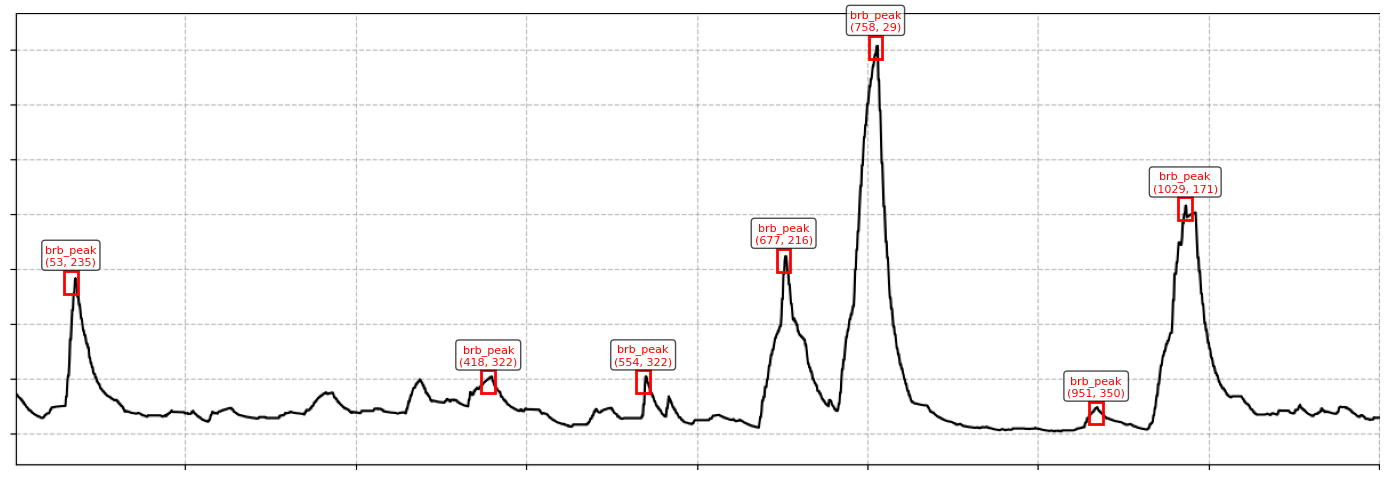

Processing windows:  94%|█████████▍| 47/50 [00:14<00:00,  3.15it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0046_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0046.png
  ✓ Created 7 bounding boxes

Processing window 48/50
  Indices: 94000 to 96000
  Number of peaks in this window: 9
Actual image size: 1200x400 pixels


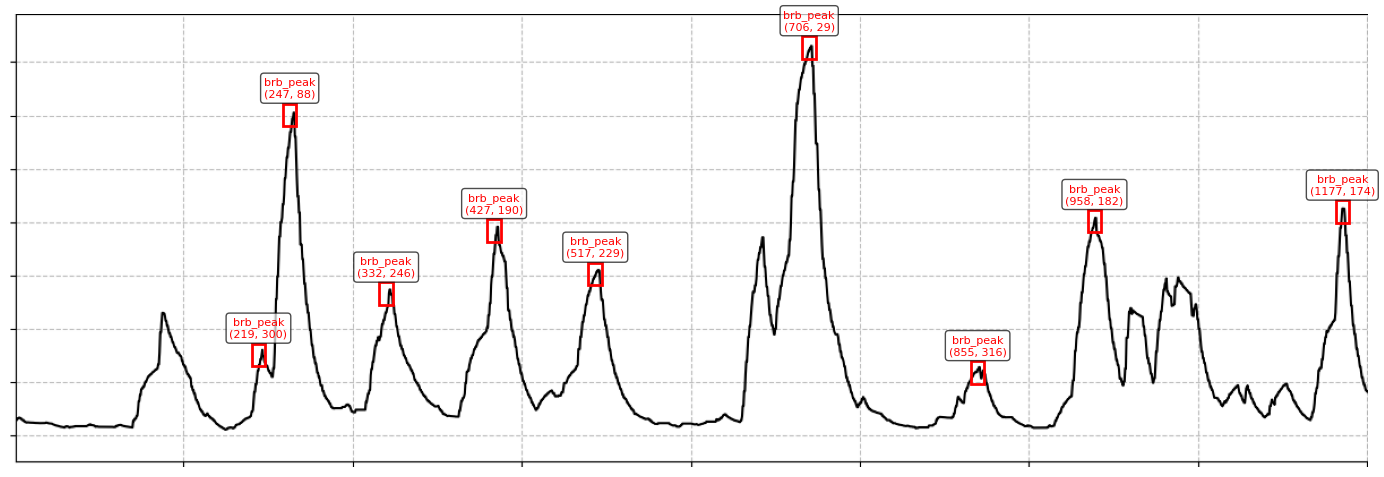

Processing windows:  96%|█████████▌| 48/50 [00:14<00:00,  3.19it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0047_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0047.png
  ✓ Created 9 bounding boxes

Processing window 49/50
  Indices: 96000 to 98000
  Number of peaks in this window: 10
Actual image size: 1200x400 pixels


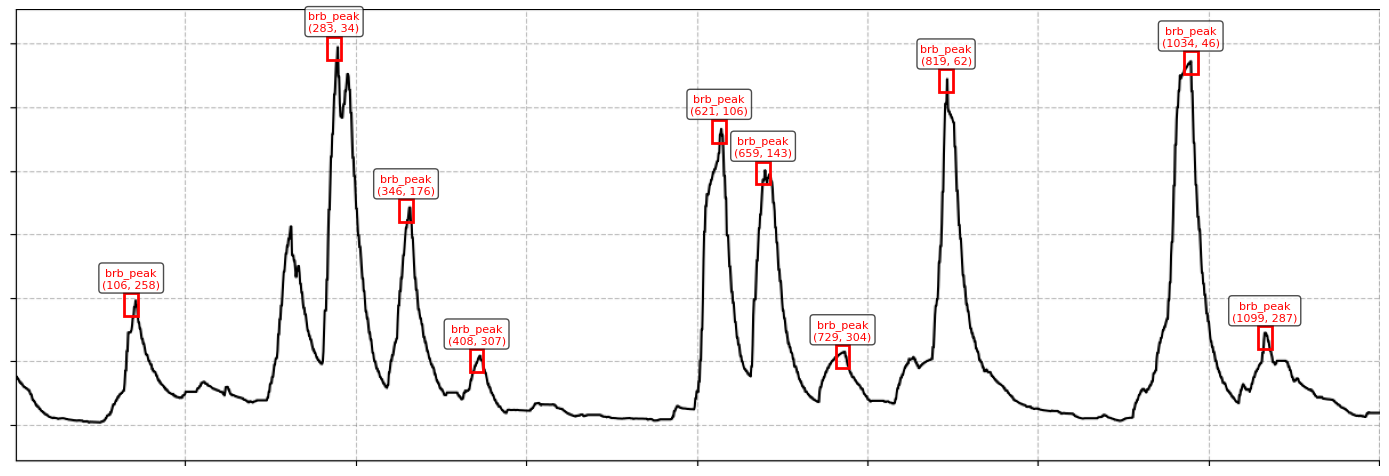

Processing windows:  98%|█████████▊| 49/50 [00:15<00:00,  3.21it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0048_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0048.png
  ✓ Created 10 bounding boxes

Processing window 50/50
  Indices: 98000 to 100000
  Number of peaks in this window: 13
Actual image size: 1200x400 pixels


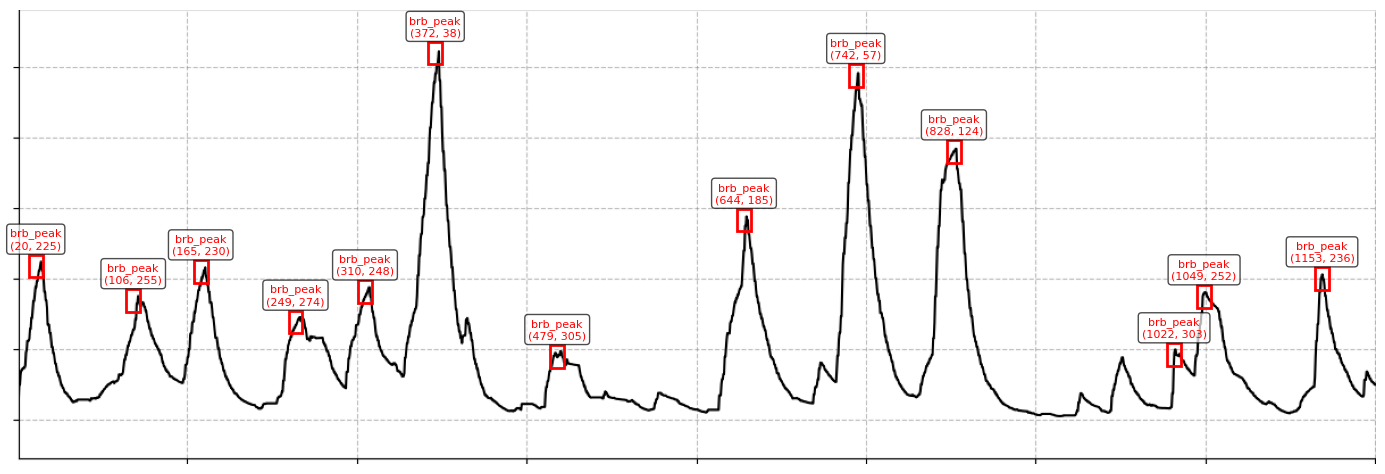

Processing windows: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s]

  Visualization saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0049_visualization.png
  ✓ Saved: ../EdiObjectDetectionData//03/images/patient_03_file_1_window_0049.png
  ✓ Created 13 bounding boxes


In [ ]:
root_path = "../../NAVA_original/000_CNN_PeakDetectionData/"
SAVE_DIR = "../EdiObjectDetectionData/"

WINDOW_SIZE = 2000
OVERLAP_SIZE = 0 # if 0 => No overlap. 
STRIDE = WINDOW_SIZE - OVERLAP_SIZE

FIGSIZE = (12, 4)
DPI = 100
PADDING = 3 # padding for the y-axis. 

NUM_WINDOWS_FOR_VISUALIZATION = 5 # Only save visualization for first 5 windows

# Class mapping for YOLO
class_mapping = {
    'brb_peak': 0,  # BbB peaks
}

# Bounding box parameters
BOX_WIDTH_RATIO = 0.01   # 1% of image width
BOX_HEIGHT_RATIO = 0.05  # 5% of image height

for patient_id in ["03"]:
    patient_data = PeakDetectPatient(patient_id, root_path)
    for edi_sample_data_dict_key in [1]: # [1, 2, 3, 4]
        total_length = len(patient_data.edi_sample_data_dict[edi_sample_data_dict_key])
        print(f"total length of edi_sample_data_dict[{edi_sample_data_dict_key}]: {total_length}")

        # Calculate number of windows
        num_windows = (total_length - WINDOW_SIZE) // STRIDE + 1
        print(f"Number of windows to process: {num_windows}")
        # Statistics tracking
        total_images = 0
        total_boxes = 0
        windows_with_peaks = 0

        # Iterate over sliding windows
        for window_idx in tqdm(range(num_windows), desc="Processing windows"):
            # Calculate window boundaries
            start_idx = window_idx * STRIDE
            end_idx = start_idx + WINDOW_SIZE
            
            # Ensure we don't go past the end
            if end_idx > total_length:
                break
            
            print(f"\n{'='*60}")
            print(f"Processing window {window_idx + 1}/{num_windows}")
            print(f"  Indices: {start_idx} to {end_idx}")
            
            # Extract timestamps for this window
            start_timestamp = patient_data.edi_sample_data_dict[edi_sample_data_dict_key]['Timestamp'].iloc[start_idx]
            end_timestamp = patient_data.edi_sample_data_dict[edi_sample_data_dict_key]['Timestamp'].iloc[end_idx - 1]
            
            # Find peaks within this window
            isin_timestamp_bbb = patient_data.peak_review_dict["BbB"]['Timestamp'].isin(
                patient_data.edi_sample_data_dict[edi_sample_data_dict_key]['Timestamp'].iloc[start_idx:end_idx]
            )
            subset_peak_review_df_bbb = patient_data.peak_review_dict["BbB"][isin_timestamp_bbb]
            
            # Extract EDI data and timestamps for this window
            edi_data = patient_data.edi_sample_data_dict[edi_sample_data_dict_key]['Edi'].iloc[start_idx:end_idx]
            timestamps = patient_data.edi_sample_data_dict[edi_sample_data_dict_key]['Timestamp'].iloc[start_idx:end_idx]
            
            # Prepare peaks data for this window
            peaks_data = []
            for idx, row in subset_peak_review_df_bbb.iterrows():
                peaks_data.append((row['Timestamp'], row['Edipeak'], "brb_peak"))
            
            print(f"  Number of peaks in this window: {len(peaks_data)}")
            


            # Image Folder
            save_image_path = f"{SAVE_DIR}/{patient_id}/images"
            label_path = f"{SAVE_DIR}/{patient_id}/labels"
            os.makedirs(save_image_path, exist_ok=True)
            os.makedirs(label_path, exist_ok=True)

            save_image_path_file_name = f"{save_image_path}/patient_{patient_id}_file_{edi_sample_data_dict_key}_window_{window_idx:04d}.png"
            save_label_path_file_name = f"{label_path}/patient_{patient_id}_file_{edi_sample_data_dict_key}_window_{window_idx:04d}.txt"

            # Step 1: Plot and save image
            try:

                metadata = plot_timeseries_with_metadata(
                    data=edi_data,
                    timestamps=timestamps,
                    save_img_path=save_image_path_file_name,
                    save_label_path=save_label_path_file_name,
                    figsize=FIGSIZE,
                    dpi=DPI,
                    padding=PADDING
                )
                
                # Step 2: Create bounding boxes from peaks
                boxes = create_bounding_boxes(
                    peaks_data=peaks_data,
                    timestamps=timestamps,
                    data=edi_data,
                    metadata=metadata,
                    box_width_ratio=BOX_WIDTH_RATIO,
                    box_height_ratio=BOX_HEIGHT_RATIO
                )
                
                # Step 3: Save YOLO format labels
                save_yolo_labels(boxes, save_label_path_file_name, class_mapping)
                
                # Step 4: Visualize for verification (optional - only for first few windows)
                if window_idx < NUM_WINDOWS_FOR_VISUALIZATION:  # Only save visualization for first 5 windows
                    viz_path = save_image_path_file_name.replace('.png', '_visualization.png')
                    visualize_bounding_boxes(save_image_path_file_name, boxes, viz_path)
                    print(f"  Visualization saved: {viz_path}")
                
                # Update statistics
                total_images += 1
                total_boxes += len(boxes)
                if len(boxes) > 0:
                    windows_with_peaks += 1
                
                print(f"  ✓ Saved: {save_image_path_file_name}")
                print(f"  ✓ Created {len(boxes)} bounding boxes")
                
            except Exception as e:
                print(f"  ✗ Error processing window {window_idx}: {str(e)}")
                continue


In [4]:


# ============================================================================
# MAIN WORKFLOW
# ============================================================================

# Your existing code
start_idx_of_edi = 5000 
end_idx_of_edi = 7000


start_timestamp_of_edi = patient_data.edi_sample_data_dict[edi_sample_data_dict_key]['Timestamp'].iloc[start_idx_of_edi]
end_timestamp_of_edi = patient_data.edi_sample_data_dict[edi_sample_data_dict_key]['Timestamp'].iloc[end_idx_of_edi]

time_diff = end_timestamp_of_edi - start_timestamp_of_edi 
print(f"Time difference: {time_diff}")

isin_timestamp_bbb = patient_data.peak_review_dict["BbB"]['Timestamp'].isin(
    patient_data.edi_sample_data_dict[edi_sample_data_dict_key]['Timestamp'].iloc[start_idx_of_edi:end_idx_of_edi])
subset_peak_review_df_bbb = patient_data.peak_review_dict["BbB"][isin_timestamp_bbb]

# Extract data
edi_data = patient_data.edi_sample_data_dict[edi_sample_data_dict_key]['Edi'].iloc[start_idx_of_edi:end_idx_of_edi]
timestamps = patient_data.edi_sample_data_dict[edi_sample_data_dict_key]['Timestamp'].iloc[start_idx_of_edi:end_idx_of_edi]

# Prepare peaks data (ground truth) - NO y_buffer needed!
peaks_data = []
for idx, row in subset_peak_review_df_bbb.iterrows():
    peaks_data.append((row['Timestamp'], row['Edipeak'], "brb_peak"))

print(f"Number of peaks: {len(peaks_data)}")

# Step 1: Plot and save image (WITHOUT peaks drawn on it)
save_path = f'patient_{patient_id}_file_{edi_sample_data_dict_key}_idx_{start_idx_of_edi}.png'
metadata = plot_timeseries_with_metadata(
    data=edi_data,
    timestamps=timestamps,
    save_path=save_path,
    figsize=(12, 4),
    dpi=100,
    padding=2  # Absolute padding value
)

print(f"Image saved: {save_path}")
print(f"Metadata saved: {save_path.replace('.png', '_metadata.json')}")

# Step 2: Create bounding boxes from peaks
boxes = create_bounding_boxes(
    peaks_data=peaks_data,
    timestamps=timestamps,
    data=edi_data,  # Pass the data array
    metadata=metadata,
    box_width_ratio=0.01,   # 2% of image width
    box_height_ratio=0.05    # 10% of image height
)

print(f"Created {len(boxes)} bounding boxes")

# Step 3: Save YOLO format labels
label_path = save_path.replace('.png', '.txt')
class_mapping = {
    'brb_peak': 0,    # BbB peaks
}

save_yolo_labels(boxes, label_path, class_mapping)
print(f"YOLO labels saved: {label_path}")

# Step 4: Visualize for verification
viz_path = save_path.replace('.png', '_visualization.png')
visualize_bounding_boxes(save_path, boxes, viz_path)
print(f"Visualization saved: {viz_path}")


Time difference: 20000
Number of peaks: 9


TypeError: plot_timeseries_with_metadata() got an unexpected keyword argument 'save_path'

In [ ]:
timestamps

5000    1050020
5001    1050030
5002    1050040
5003    1050050
5004    1050060
         ...   
6995    1069970
6996    1069980
6997    1069990
6998    1070000
6999    1070010
Name: Timestamp, Length: 2000, dtype: int64

In [ ]:
metadata

{'image_path': 'patient_your_patient_id_file_2_idx_5000.png',
 'image_width': 1200,
 'image_height': 400,
 'timestamp_min': '1050020',
 'timestamp_max': '1070010',
 'timestamp_range': 19990.0,
 'data_min': 0.24,
 'data_max': 23.38,
 'y_min_plot': 0.13999999999999999,
 'y_max_plot': 23.48,
 'y_range_plot': 23.34,
 'num_datapoints': 2000,
 'figsize': (12, 4),
 'dpi': 100}

In [ ]:
peaks_data

[(np.float64(1052010.0), np.float64(6.17), 'brb_peak'),
 (np.float64(1054090.0), np.float64(10.87), 'brb_peak'),
 (np.float64(1056160.0), np.float64(9.5), 'brb_peak'),
 (np.float64(1058550.0), np.float64(5.46), 'brb_peak'),
 (np.float64(1060380.0), np.float64(4.55), 'brb_peak'),
 (np.float64(1061120.0), np.float64(9.13), 'brb_peak'),
 (np.float64(1062540.0), np.float64(14.73), 'brb_peak'),
 (np.float64(1063770.0), np.float64(23.38), 'brb_peak'),
 (np.float64(1065680.0), np.float64(20.19), 'brb_peak')]

In [ ]:
for sample_data_dict_key in [1, 2, 3, 4]:
    sample_data_df = patient_data.edi_sample_data_dict[sample_data_dict_key]
    # print(sample_data_df.head())
    # print(sample_data_df.tail())
    # print(sample_data_df.shape)
    print(sample_data_df['Edi'].describe())

count    100000.000000
mean          5.415813
std           8.280348
min           0.000000
25%           0.930000
50%           2.220000
75%           6.430000
max         144.240000
Name: Edi, dtype: float64
count    100000.000000
mean          3.541019
std           3.825564
min           0.000000
25%           1.040000
50%           2.190000
75%           4.630000
max          38.480000
Name: Edi, dtype: float64
count    100000.000000
mean          4.135110
std           4.628672
min           0.000000
25%           1.130000
50%           2.460000
75%           5.520000
max          48.080000
Name: Edi, dtype: float64
count    100000.000000
mean          2.788276
std           3.094605
min           0.000000
25%           0.910000
50%           1.910000
75%           3.560000
max          53.620000
Name: Edi, dtype: float64


In [ ]:


def save_yolo_labels(boxes, save_path, class_mapping={'blue': 0, 'red': 1, 'orange': 2, 'green': 3}):
    """
    Save bounding boxes in YOLO format
    
    Args:
        boxes: list of box dicts from create_bounding_boxes
        save_path: path to save .txt file
        class_mapping: dict mapping label names to class IDs
    
    Format: <class_id> <x_center> <y_center> <width> <height> (all normalized 0-1)
    """
    with open(save_path, 'w') as f:
        for box in boxes:
            label = box['label']
            class_id = class_mapping.get(label, 0)  # Default to 0 if label not in mapping
            
            bbox = box['bbox_normalized']
            f.write(f"{class_id} {bbox['x_center']:.6f} {bbox['y_center']:.6f} "
                   f"{bbox['width']:.6f} {bbox['height']:.6f}\n")


def visualize_bounding_boxes(image_path, boxes, save_path=None):
    """
    Visualize the bounding boxes on the image for verification
    
    Args:
        image_path: path to the saved image
        boxes: list of box dicts from create_bounding_boxes
        save_path: optional path to save visualization
    """
    from PIL import Image
    import matplotlib.patches as patches
    
    img = Image.open(image_path)
    fig, ax = plt.subplots(1, figsize=(14, 5))
    ax.imshow(img)
    
    # Color mapping for visualization
    color_map = {'blue': 'blue', 'red': 'red', 'orange': 'orange', 'green': 'green'}
    
    for box in boxes:
        bbox_px = box['bbox_pixels']
        label = box['label']
        color = color_map.get(label, 'yellow')
        
        # Calculate corner position (top-left)
        x_min = bbox_px['x_center'] - bbox_px['width'] / 2
        y_min = bbox_px['y_center'] - bbox_px['height'] / 2
        
        # Draw rectangle
        rect = patches.Rectangle(
            (x_min, y_min), bbox_px['width'], bbox_px['height'],
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        ax.text(bbox_px['x_center'], y_min - 5, label, 
                color=color, fontsize=8, ha='center',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # plt.title('Bounding Boxes Visualization (for verification only)')
    plt.axis('off')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.show()
    plt.close()
